In [4]:
import matplotlib.pyplot as plt
from skimage.transform import rescale, resize
import os
import numpy as np
from demo_utils import plot_image
import svmbir
from scipy.interpolate import interp1d
from scipy import ndimage as nd
from scipy.interpolate import RegularGridInterpolator
import matplotlib.patches as mpatches

In [4]:
def padding(array, xx, yy):
    """
    :param array: numpy array
    :param xx: desired height
    :param yy: desired width
    :return: padded array
    """

    h = array.shape[0]
    w = array.shape[1]

    a = (xx - h) // 2
    aa = xx - a - h

    b = (yy - w) // 2
    bb = yy - b - w

    return np.pad(array, pad_width=((a, aa), (b, bb)))

In [72]:
def create_number_line(start, end, tick_positions,color,index=True, annot_above=True,annotate=True):
    plt.xlim(start, end)
    height=0.25
    plt.ylim(0, height)  # Set a small y-axis range for the tick marks
    annot_loc=height+0.02
    if annot_above==False:
        annot_loc=-0.08
    # Draw tick marks
    for i,tick in enumerate(tick_positions):
        plt.axvline(tick, color=color, linestyle='-', linewidth=2)
        if annotate:
            plt.text(tick+0.17, annot_loc, str(round(tick,2)), ha='center', fontsize=10)
            if index:
                plt.text(tick-0.17, -0.05,'$r_{{{}}}$'.format(i), ha='center', fontsize=10)

    plt.axhline(y=height/2, color='black', linestyle='-', linewidth=2)  # Adjust y position as needed

    # Save the figure as an image
    plt.axis('off')  # Hide axes

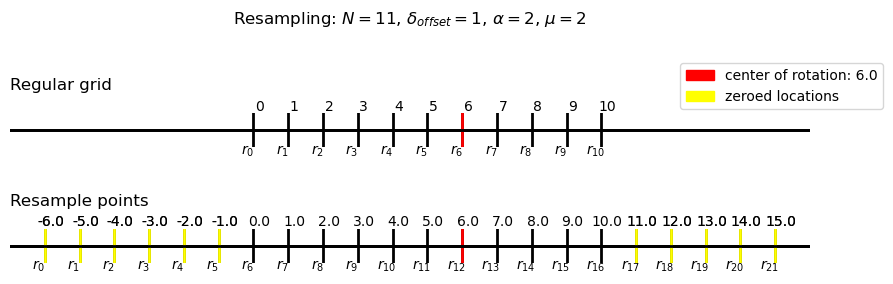

In [82]:

N=11
offset=1
alpha=2
mu=2
center=[offset+(N-1)/2]

c=np.linspace(0,N-1,N)
r=np.zeros(int(round(N*mu)))
r[0]= ((N-1)/2 + offset)*(1- alpha)
for i in range(int(round(N*mu))):
    r[i]=r[0] + (alpha/mu)*i


left_limit=r[0]-1
right_limit=r[-1]+1

plt.figure(figsize=(8, 2.5))

plt.subplot(2,1,1)
create_number_line(left_limit,right_limit,np.linspace(0,N-1,N).astype(int),'black')
create_number_line(left_limit,right_limit,center,'red',annotate=False)
plt.title("Regular grid",loc='left',y=1.45)

plt.subplot(2,1,2)
create_number_line(left_limit,right_limit,r,'black')
create_number_line(left_limit,right_limit,center,'red',annotate=False)
create_number_line(left_limit,right_limit,r[(r>N-1)|(r<0)],'yellow',index=False)
plt.title("Resample points",loc='left',y=1.450)
plt.suptitle("Resampling: $N={}$, $\delta_{{offset}}={}$, $\\alpha={}$, $\\mu={}$".format(N,offset,alpha,mu),y=1.1)
plt.tight_layout(pad=0)
red_patch = mpatches.Patch(color='red', label='center of rotation: {}'.format(center[0]))
yellow_patch = mpatches.Patch(color='yellow', label='zeroed locations')
plt.legend(handles=[red_patch,yellow_patch],bbox_to_anchor=(1.1,6.1),loc='upper right')
plt.show()

In [182]:
right_limit

1.0

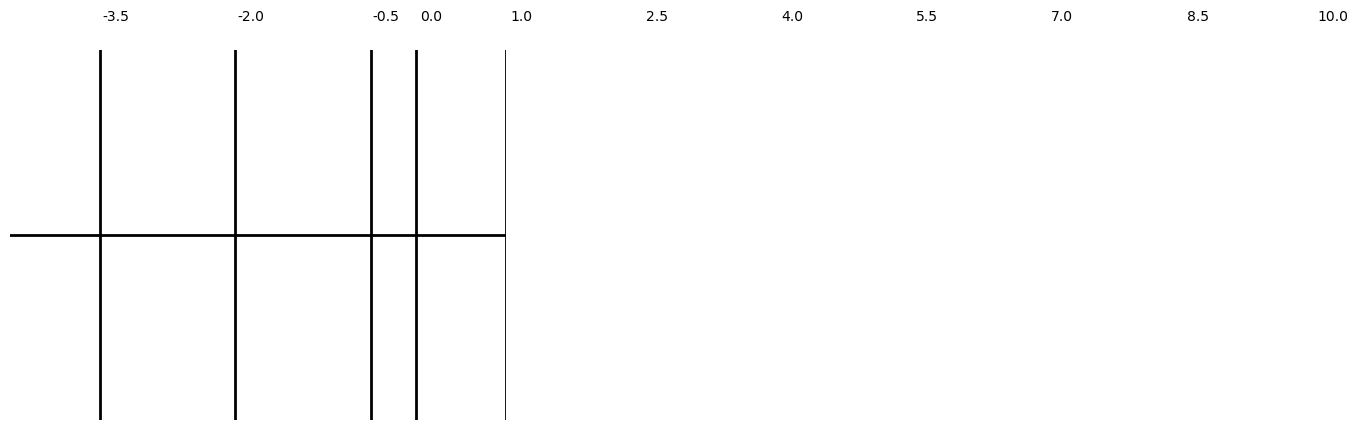

In [181]:
create_number_line(left_limit,right_limit,r,'black')

In [146]:
r[(r>9)|(r<0)]

array([-3.25, -1.75, -0.25, 10.25])

In [145]:
r>9

array([False, False, False, False, False, False, False, False, False,
        True])

In [16]:
def grid_rescale_and_pad(arr,rescale_factor,upsample_factor=1,center_offset=0,method="cubic"):
    col_scale=rescale_factor
    num_rows,num_cols = arr.shape
    row_grid = np.linspace(0,num_rows-1,num_rows)
    col_grid = np.linspace(0,num_cols-1,num_cols)

    interp=RegularGridInterpolator((row_grid,col_grid),arr,method=method,bounds_error=False,fill_value=0)
    row_interpts=row_grid
    new_length=int(round(num_cols*upsample_factor))
    col_interpts=np.zeros(new_length)
    col_interpts[0]= ((num_cols-1)/2 + center_offset)*(1- col_scale)
    for i in range(new_length):
        col_interpts[i]=col_interpts[0] + (col_scale/upsample_factor)*i

    row_mesh,col_mesh = np.meshgrid(row_interpts,col_interpts)
    scaled_arr = interp((row_mesh,col_mesh))
    return np.transpose(scaled_arr)

In [24]:
def grid_rescale_and_pad_old(arr,rescale_factor,method="cubic"):
    row_scale,col_scale=rescale_factor
    num_rows,num_cols = arr.shape
    if (num_rows % 2) == 0: #even
        row_grid = np.linspace(-num_rows/2+1/2,num_rows/2-1/2,num_rows)
    else: #odd
        row_grid = np.linspace(-(num_rows-1)/2, (num_rows-1)/2,num_rows)
    if (num_cols % 2) == 0: #even
        col_grid = np.linspace(-num_cols/2+1/2,num_cols/2-1/2,num_cols)
    else: #odd
        col_grid = np.linspace(-(num_cols-1)/2,(num_cols-1)/2,num_cols)

    interp=RegularGridInterpolator((row_grid,col_grid),arr,method=method,bounds_error=False,fill_value=0)
    row_interpts=row_grid*row_scale
    col_interpts=col_grid*col_scale
    row_mesh,col_mesh = np.meshgrid(row_interpts,col_interpts)
    scaled_arr = interp((row_mesh,col_mesh))
    return np.transpose(scaled_arr)
        #,row_interpts,col_interpts,row_grid,col_grid


In [18]:
def alt_scale(image,factor):
    return nd.zoom(image,(1,factor),order=1,mode='reflect',cval=0,grid_mode=False)

def ARC_sino_transform_old(sino,angles,gamma):
    num_channels=sino.shape[2]
    num_slices = sino.shape[1]
    sino_tilde= np.zeros(sino.shape)
    new_angles=np.zeros(angles.shape)
    for thetaidx, theta in enumerate(angles):
        if theta==np.pi/2:
            theta_tilde= np.pi/2
        else:
            theta_tilde= np.arctan2(gamma*np.sin(theta),np.cos(theta))

        beta= np.sqrt((gamma**2)*(np.sin(theta)**2)+np.cos(theta)**2)/gamma
        if theta_tilde==0:
            alpha=gamma
        else:
            alpha= gamma*np.sin(theta)/np.sin(theta_tilde)
        sino_tilde[thetaidx,:,:]=padding(
            beta*rescale(sino[thetaidx,:,:],(1,1/alpha),preserve_range=True)
            ,num_slices,num_channels)
        new_angles[thetaidx]=theta_tilde
    return sino_tilde, new_angles

In [19]:
def ARC_sino_transform(sino,angles,gamma,mu=1,center_offset=0,method='cubic'):
    num_channels=sino.shape[2]
    num_slices = sino.shape[1]
    new_channels=int(round(sino.shape[2]*mu))
    sino_tilde= np.zeros((sino.shape[0],num_slices,new_channels))
    new_angles=np.zeros(angles.shape)
    for thetaidx, theta in enumerate(angles):
        if theta==np.pi/2:
            theta_tilde= np.pi/2
        else:
            theta_tilde= np.arctan2(gamma*np.sin(theta),np.cos(theta))

        beta= np.sqrt((gamma**2)*(np.sin(theta)**2)+np.cos(theta)**2)/gamma
        if theta_tilde==0:
            alpha=gamma
        else:
            alpha= gamma*np.sin(theta)/np.sin(theta_tilde)

        sino_tilde[thetaidx,:,:]=beta*grid_rescale_and_pad(sino[thetaidx,:,:],alpha,mu,center_offset=center_offset,method=method)

        new_angles[thetaidx]=theta_tilde
    return sino_tilde, new_angles

In [89]:
def ARC_Test(gamma,mu,theta_range,num_views,compress_vertical=False,interpolate=False):
    num_rows = 256
    num_cols = 64
    num_slices = 33
    # display_slice = 16 # Display slice at z=-0.0
    tilt_angle=theta_range
    # Reconstruction parameters
    snr_db = 30.0
    sharpness = 0.0
    T = 0.25
    p = 1.2
    # Display parameters
    vmin = 0.0
    vmax = 1.1
    phantom = svmbir.phantom.gen_microscopy_sample_3d(num_rows,num_cols,num_slices)
    if compress_vertical:
        phantom= np.rot90(phantom,axes=(1,2))
        num_rows=64
        num_cols=256

    # Generate the array of view angles
    angles = np.linspace(-tilt_angle, tilt_angle, num_views)

    # Generate sinogram by projecting phantom
    sino = svmbir.project(phantom, angles, max(num_rows, num_cols))

    sino_tilde, new_angles = ARC_sino_transform(sino,angles,gamma,mu)

    # Determine resulting number of views, slices, and channels
    (num_views, num_slices, num_channels) = sino_tilde.shape

    true_delta_channel=sino.shape[2]/sino_tilde.shape[2]
    # Perform MBIR reconstruction
    recon = svmbir.recon(sino_tilde, new_angles, num_rows=num_rows, num_cols=int(round(num_cols/gamma)), T=T, p=p, sharpness=sharpness, snr_db=snr_db,delta_channel=true_delta_channel,delta_pixel=1)

    if interpolate:
        recon=rescale(recon,(1,1,gamma))
    else:
        phantom=rescale(phantom,(1,1,1/gamma))

    nrmse = svmbir.phantom.nrmse(recon, phantom)

    if compress_vertical:
        phantom= np.rot90(phantom,k=-1,axes=(1,2))
        recon= np.rot90(recon,k=-1,axes=(1,2))

    return recon, phantom, nrmse, sino, sino_tilde

In [85]:
def even_interp_sino(sino2d,bad_angles,reg_angles):
    even_sino=np.empty((sino2d.shape[0], len(reg_angles)))
    for i in range(even_sino.shape[0]):
        f = interp1d(bad_angles, sino2d[i, :], kind='linear', fill_value="extrapolate")
        even_sino[i, :] = f(reg_angles)
    return even_sino

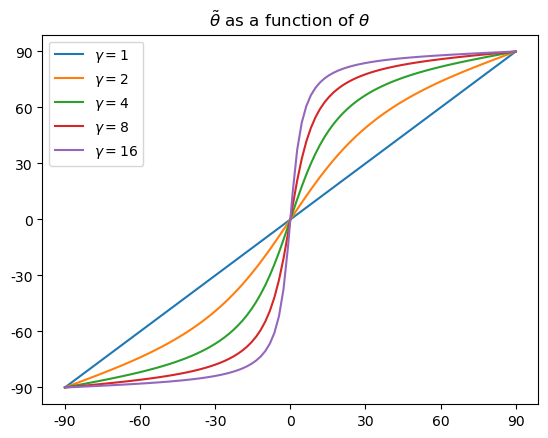

In [130]:
def theta_tildefunc(theta,gamma):
    return np.arctan2(gamma*np.sin(theta),np.cos(theta))

def alphafunc(theta,gamma):
    theta_tilde=theta_tildefunc(theta,gamma)
    return gamma*np.sin(theta)/np.sin(theta_tilde)

def betafunc(theta,gamma):
    return np.sqrt((gamma**2)*(np.sin(theta)**2)+np.cos(theta)**2)/gamma

x = np.linspace(-np.pi/2,np.pi/2,100)
plt.plot(x,theta_tildefunc(x,1))
plt.plot(x,theta_tildefunc(x,2))
plt.plot(x,theta_tildefunc(x,4))
plt.plot(x,theta_tildefunc(x,8))
plt.plot(x,theta_tildefunc(x,16))
plt.legend(["$\gamma=1$","$\gamma=2$","$\gamma=4$","$\gamma=8$","$\gamma=16$"])
plt.title("$\~\\theta$ as a function of $\\theta$")
plt.xticks(np.linspace(-np.pi/2,np.pi/2,7), np.arange(-90,91,180/6,dtype=int))
plt.yticks(np.linspace(-np.pi/2,np.pi/2,7), np.arange(-90,91,180/6,dtype=int))
plt.show()


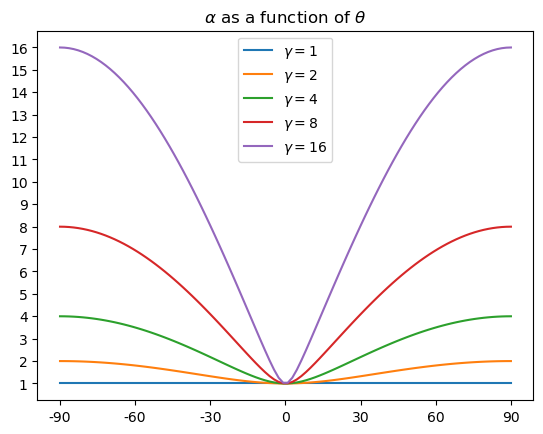

In [132]:
plt.plot(x,alphafunc(x,1))
plt.plot(x,alphafunc(x,2))
plt.plot(x,alphafunc(x,4))
plt.plot(x,alphafunc(x,8))
plt.plot(x,alphafunc(x,16))
plt.legend(["$\gamma=1$","$\gamma=2$","$\gamma=4$","$\gamma=8$","$\gamma=16$"])
plt.title("$\\alpha$ as a function of $\\theta$")
plt.xticks(np.linspace(-np.pi/2,np.pi/2,7), np.arange(-90,91,180/6,dtype=int))
plt.yticks(np.linspace(1,16,16))
plt.show()

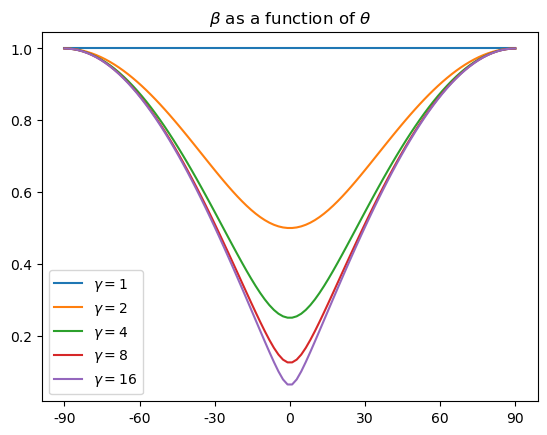

In [133]:
plt.plot(x,betafunc(x,1))
plt.plot(x,betafunc(x,2))
plt.plot(x,betafunc(x,4))
plt.plot(x,betafunc(x,8))
plt.plot(x,betafunc(x,16))
plt.legend(["$\gamma=1$","$\gamma=2$","$\gamma=4$","$\gamma=8$","$\gamma=16$"])
plt.title("$\\beta$ as a function of $\\theta$")
plt.xticks(np.linspace(-np.pi/2,np.pi/2,7), np.arange(-90,91,180/6,dtype=int))
plt.show()

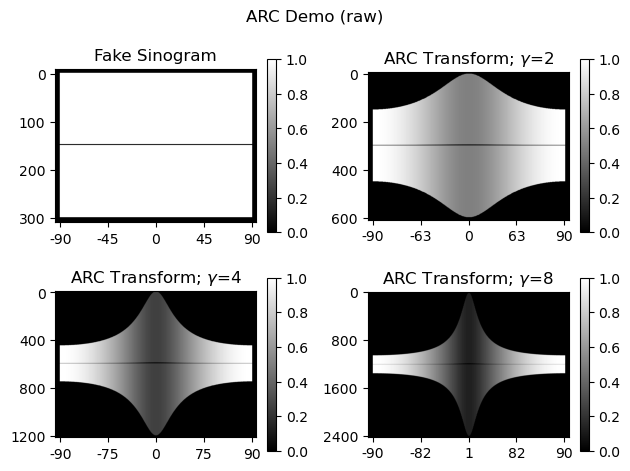

In [83]:
views=400
offset=0
tilt_angle=np.pi/2
a, b = -tilt_angle, tilt_angle
fake_sino=np.ones((views,1,300))
fake_sino[:,:,int((300-1)/2)+offset-1:int((300-1)/2)+offset+1] -= 1
fake_angles=np.linspace(-tilt_angle, tilt_angle, views)
plt.subplot(2,2,1)
plt.imshow(np.pad(np.transpose(fake_sino[:,0,:]),(10,10)),cmap='grey')
plt.xticks(np.linspace(10, fake_sino.shape[0]+10, 5), np.arange(-90,91,180/4,dtype=int))
plt.yticks(np.linspace(10, fake_sino.shape[2]+10, 4), np.arange(0,301,300/3,dtype=int))
plt.colorbar(fraction=0.040)
plt.title('Fake Sinogram')

gamma=2
new_channel=gamma*300
fake_sino_tilde, fake_angles_tilde = ARC_sino_transform(fake_sino,fake_angles,gamma,gamma,center_offset=offset,method='linear')
plt.subplot(2,2,2)
plt.imshow(np.pad(np.transpose(fake_sino_tilde[:,0,:]),(10,10)),cmap='grey')
trans_tics=(180*fake_angles_tilde[np.round(np.linspace(0, len(fake_angles_tilde)-1, 5)).astype(int)]/np.pi).astype(int)
plt.xticks(np.linspace(10, fake_sino.shape[0]+10, 5), trans_tics)
plt.yticks(np.linspace(10, fake_sino_tilde.shape[2]+10, 4), np.arange(0,new_channel+1,new_channel/3,dtype=int))
plt.gca().set_aspect(400/(views*gamma))
plt.colorbar(fraction=0.040)
plt.title('ARC Transform; $\gamma$={}'.format(gamma))

gamma=4
new_channel=gamma*300
fake_sino_tilde, fake_angles_tilde = ARC_sino_transform(fake_sino,fake_angles,gamma,gamma,center_offset=offset,method='linear')
plt.subplot(2,2,3)
plt.imshow(np.pad(np.transpose(fake_sino_tilde[:,0,:]),(10,10)),cmap='grey')
trans_tics=(180*fake_angles_tilde[np.round(np.linspace(0, len(fake_angles_tilde)-1, 5)).astype(int)]/np.pi).astype(int)
plt.xticks(np.linspace(10, fake_sino.shape[0]+10, 5), trans_tics)
plt.yticks(np.linspace(10, fake_sino_tilde.shape[2]+10, 4), np.arange(0,new_channel+1,new_channel/3,dtype=int))
plt.gca().set_aspect(400/(views*gamma))
plt.colorbar(fraction=0.040)
plt.title('ARC Transform; $\gamma$={}'.format(gamma))

gamma=8
new_channel=gamma*300
fake_sino_tilde, fake_angles_tilde = ARC_sino_transform(fake_sino,fake_angles,gamma,gamma,center_offset=offset, method='linear')
plt.subplot(2,2,4)
plt.imshow(np.pad(np.transpose(fake_sino_tilde[:,0,:]),(10,10)),cmap='grey')
trans_tics=(180*fake_angles_tilde[np.round(np.linspace(0, len(fake_angles_tilde)-1, 5)).astype(int)]/np.pi).astype(int)
plt.xticks(np.linspace(10, fake_sino.shape[0]+10, 5), trans_tics)
plt.yticks(np.linspace(10, fake_sino_tilde.shape[2]+10, 4), np.arange(0,new_channel+1,new_channel/3,dtype=int))
plt.gca().set_aspect(400/(views*gamma))
plt.colorbar(fraction=0.040)
plt.title('ARC Transform; $\gamma$={}'.format(gamma))

plt.suptitle('ARC Demo (raw)')
plt.tight_layout()

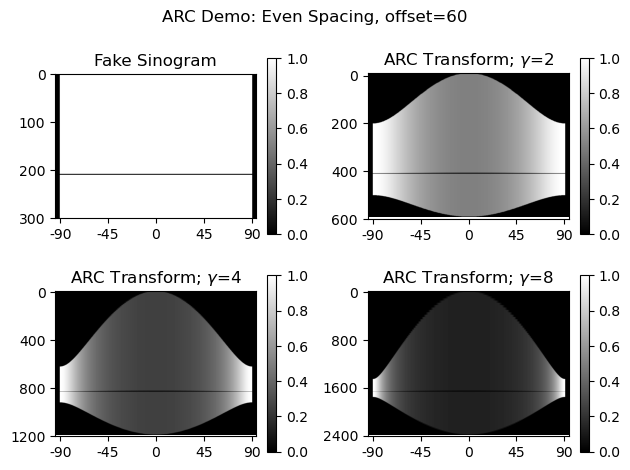

In [88]:
offset=60
views=400
tilt_angle=np.pi/2
a, b = -tilt_angle, tilt_angle
fake_sino=np.ones((views,1,300))
fake_sino[:,:,int((300-1)/2)+offset-1:int((300-1)/2)+offset+1] -= 1
fake_angles=np.linspace(-tilt_angle, tilt_angle, views)
plt.subplot(2,2,1)
npad=((0,0),(10,10))
plt.imshow(np.pad(np.transpose(fake_sino[:,0,:]),npad),cmap='grey')
plt.xticks(np.linspace(10, fake_sino.shape[0]+10, 5), np.arange(-90,91,180/4,dtype=int))
plt.yticks(np.linspace(0, fake_sino.shape[2], 4), np.arange(0,301,300/3,dtype=int))
plt.colorbar(fraction=0.040)
plt.title('Fake Sinogram')

gamma=2
new_channel=gamma*300
fake_sino_tilde, fake_angles_tilde = ARC_sino_transform(fake_sino,fake_angles,gamma,gamma,center_offset=offset,method='linear')
plt.subplot(2,2,2)
sino_tilde=np.transpose(fake_sino_tilde[:,0,:])
sino_interp=even_interp_sino(sino_tilde,fake_angles_tilde,fake_angles)
plt.imshow(np.pad(sino_interp,npad),cmap='grey')
plt.xticks(np.linspace(10, fake_sino.shape[0]+10, 5), np.arange(-90,91,180/4,dtype=int))
plt.yticks(np.linspace(10, fake_sino_tilde.shape[2]+10, 4), np.arange(0,new_channel+1,new_channel/3,dtype=int))
plt.gca().set_aspect(400/(views*gamma))
plt.colorbar(fraction=0.040)
plt.title('ARC Transform; $\gamma$={}'.format(gamma))

gamma=4
new_channel=gamma*300
fake_sino_tilde, fake_angles_tilde = ARC_sino_transform(fake_sino,fake_angles,gamma,gamma,center_offset=offset,method='linear')
plt.subplot(2,2,3)
sino_tilde=np.transpose(fake_sino_tilde[:,0,:])
sino_interp=even_interp_sino(sino_tilde,fake_angles_tilde,fake_angles)
plt.imshow(np.pad(sino_interp,npad),cmap='grey')
plt.xticks(np.linspace(10, fake_sino.shape[0]+10, 5), np.arange(-90,91,180/4,dtype=int))
plt.yticks(np.linspace(10, fake_sino_tilde.shape[2]+10, 4), np.arange(0,new_channel+1,new_channel/3,dtype=int))
plt.gca().set_aspect(400/(views*gamma))
plt.colorbar(fraction=0.040)
plt.title('ARC Transform; $\gamma$={}'.format(gamma))

gamma=8
new_channel=gamma*300
fake_sino_tilde, fake_angles_tilde = ARC_sino_transform(fake_sino,fake_angles,gamma,gamma,center_offset=offset,method='linear')
plt.subplot(2,2,4)
sino_tilde=np.transpose(fake_sino_tilde[:,0,:])
sino_interp=even_interp_sino(sino_tilde,fake_angles_tilde,fake_angles)
plt.imshow(np.pad(sino_interp,npad),cmap='grey')
plt.xticks(np.linspace(10, fake_sino.shape[0]+10, 5), np.arange(-90,91,180/4,dtype=int))
plt.yticks(np.linspace(10, fake_sino_tilde.shape[2]+10, 4), np.arange(0,new_channel+1,new_channel/3,dtype=int))
plt.gca().set_aspect(400/(views*gamma))
plt.colorbar(fraction=0.040)
plt.title('ARC Transform; $\gamma$={}'.format(gamma))

plt.suptitle('ARC Demo: Even Spacing, offset={}'.format(offset))
plt.tight_layout()

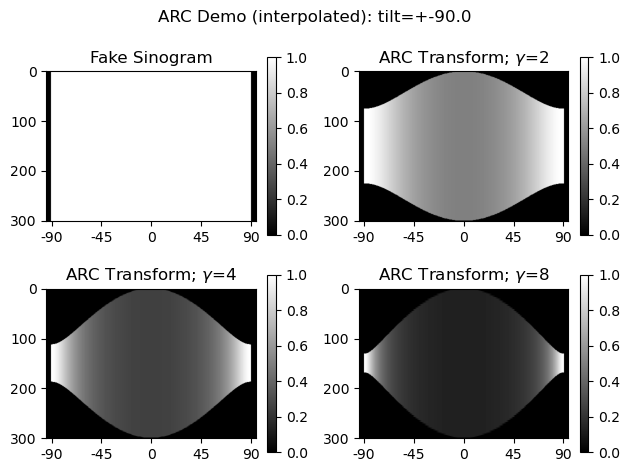

In [90]:
imwidth=400
views=int(400/1)
tilt_angle=np.pi/2
a, b = -tilt_angle, tilt_angle
fake_sino=np.ones((views,1,300))
fake_angles=np.linspace(-tilt_angle, tilt_angle, views)
plt.subplot(2,2,1)
npad=((0,0),(int((imwidth-views)/2)+10,int((imwidth-views)/2)+10))
plt.imshow(np.pad(np.transpose(fake_sino[:,0,:]),npad),cmap='grey')
plt.xticks(np.linspace(10, imwidth+10, 5), np.arange(-90,91,180/4,dtype=int))
plt.yticks(np.linspace(0, fake_sino.shape[2], 4), np.arange(0,301,300/3,dtype=int))
plt.colorbar(fraction=0.040)
plt.title('Fake Sinogram')

gamma=2
fake_sino_tilde, fake_angles_tilde = ARC_sino_transform(fake_sino,fake_angles,gamma,method='linear')
plt.subplot(2,2,2)
sino_tilde=np.transpose(fake_sino_tilde[:,0,:])
reg_ang=np.linspace(fake_angles_tilde.min(), fake_angles_tilde.max(), num=int(views*fake_angles_tilde.max()/tilt_angle))
sino_interp=even_interp_sino(sino_tilde,fake_angles_tilde,reg_ang)
npad=((0,0),(int((imwidth-len(reg_ang))/2)+10,int((imwidth-len(reg_ang))/2)+10))
plt.imshow(np.pad(sino_interp,npad),cmap='grey')
plt.xticks(np.linspace(10, imwidth+10, 5), np.arange(-90,91,180/4,dtype=int))
plt.yticks(np.linspace(0, fake_sino.shape[2], 4), np.arange(0,301,300/3,dtype=int))
plt.colorbar(fraction=0.040)
plt.title('ARC Transform; $\gamma$={}'.format(gamma))

gamma=4
fake_sino_tilde, fake_angles_tilde = ARC_sino_transform(fake_sino,fake_angles,gamma,method='linear')
plt.subplot(2,2,3)
sino_tilde=np.transpose(fake_sino_tilde[:,0,:])
reg_ang=np.linspace(fake_angles_tilde.min(), fake_angles_tilde.max(), num=int(views*fake_angles_tilde.max()/tilt_angle))
sino_interp=even_interp_sino(sino_tilde,fake_angles_tilde,reg_ang)
npad=((0,0),(int((imwidth-len(reg_ang))/2)+10,int((imwidth-len(reg_ang))/2)+10))
plt.imshow(np.pad(sino_interp,npad),cmap='grey')
plt.xticks(np.linspace(10, imwidth+10, 5), np.arange(-90,91,180/4,dtype=int))
plt.yticks(np.linspace(0, fake_sino.shape[2], 4), np.arange(0,301,300/3,dtype=int))
plt.colorbar(fraction=0.040)
plt.title('ARC Transform; $\gamma$={}'.format(gamma))

gamma=8
fake_sino_tilde, fake_angles_tilde = ARC_sino_transform(fake_sino,fake_angles,gamma,method='linear')
plt.subplot(2,2,4)
sino_tilde=np.transpose(fake_sino_tilde[:,0,:])
reg_ang=np.linspace(fake_angles_tilde.min(), fake_angles_tilde.max(), num=int(views*fake_angles_tilde.max()/tilt_angle))
sino_interp=even_interp_sino(sino_tilde,fake_angles_tilde,reg_ang)
npad=((0,0),(int((imwidth-len(reg_ang))/2)+10,int((imwidth-len(reg_ang))/2)+10))
plt.imshow(np.pad(sino_interp,npad),cmap='grey')
plt.xticks(np.linspace(10, imwidth+10, 5), np.arange(-90,91,180/4,dtype=int))
plt.yticks(np.linspace(0, fake_sino.shape[2], 4), np.arange(0,301,300/3,dtype=int))
plt.colorbar(fraction=0.040)
plt.title('ARC Transform; $\gamma$={}'.format(gamma))

plt.suptitle('ARC Demo (interpolated): tilt=+-{}'.format(tilt_angle*180/np.pi))
plt.tight_layout()

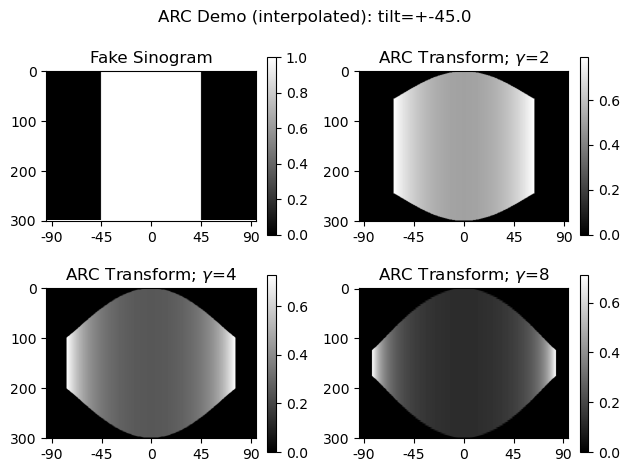

In [91]:
imwidth=400
views=int(400/2)
tilt_angle=np.pi/4
a, b = -tilt_angle, tilt_angle
fake_sino=np.ones((views,1,300))
fake_angles=np.linspace(-tilt_angle, tilt_angle, views)
plt.subplot(2,2,1)
npad=((0,0),(int((imwidth-views)/2)+10,int((imwidth-views)/2)+10))
plt.imshow(np.pad(np.transpose(fake_sino[:,0,:]),npad),cmap='grey')
plt.xticks(np.linspace(10, imwidth+10, 5), np.arange(-90,91,180/4,dtype=int))
plt.yticks(np.linspace(0, fake_sino.shape[2], 4), np.arange(0,301,300/3,dtype=int))
plt.colorbar(fraction=0.040)
plt.title('Fake Sinogram')

gamma=2
fake_sino_tilde, fake_angles_tilde = ARC_sino_transform(fake_sino,fake_angles,gamma,method='linear')
plt.subplot(2,2,2)
sino_tilde=np.transpose(fake_sino_tilde[:,0,:])
reg_ang=np.linspace(fake_angles_tilde.min(), fake_angles_tilde.max(), num=int(views*fake_angles_tilde.max()/tilt_angle))
sino_interp=even_interp_sino(sino_tilde,fake_angles_tilde,reg_ang)
npad=((0,0),(int((imwidth-len(reg_ang))/2)+10,int((imwidth-len(reg_ang))/2)+10))
plt.imshow(np.pad(sino_interp,npad),cmap='grey')
plt.xticks(np.linspace(10, imwidth+10, 5), np.arange(-90,91,180/4,dtype=int))
plt.yticks(np.linspace(0, fake_sino.shape[2], 4), np.arange(0,301,300/3,dtype=int))
plt.colorbar(fraction=0.040)
plt.title('ARC Transform; $\gamma$={}'.format(gamma))

gamma=4
fake_sino_tilde, fake_angles_tilde = ARC_sino_transform(fake_sino,fake_angles,gamma,method='linear')
plt.subplot(2,2,3)
sino_tilde=np.transpose(fake_sino_tilde[:,0,:])
reg_ang=np.linspace(fake_angles_tilde.min(), fake_angles_tilde.max(), num=int(views*fake_angles_tilde.max()/tilt_angle))
sino_interp=even_interp_sino(sino_tilde,fake_angles_tilde,reg_ang)
npad=((0,0),(int((imwidth-len(reg_ang))/2)+10,int((imwidth-len(reg_ang))/2)+10))
plt.imshow(np.pad(sino_interp,npad),cmap='grey')
plt.xticks(np.linspace(10, imwidth+10, 5), np.arange(-90,91,180/4,dtype=int))
plt.yticks(np.linspace(0, fake_sino.shape[2], 4), np.arange(0,301,300/3,dtype=int))
plt.colorbar(fraction=0.040)
plt.title('ARC Transform; $\gamma$={}'.format(gamma))

gamma=8
fake_sino_tilde, fake_angles_tilde = ARC_sino_transform(fake_sino,fake_angles,gamma,method='linear')
plt.subplot(2,2,4)
sino_tilde=np.transpose(fake_sino_tilde[:,0,:])
reg_ang=np.linspace(fake_angles_tilde.min(), fake_angles_tilde.max(), num=int(views*fake_angles_tilde.max()/tilt_angle))
sino_interp=even_interp_sino(sino_tilde,fake_angles_tilde,reg_ang)
npad=((0,0),(int((imwidth-len(reg_ang))/2)+10,int((imwidth-len(reg_ang))/2)+10))
plt.imshow(np.pad(sino_interp,npad),cmap='grey')
plt.xticks(np.linspace(10, imwidth+10, 5), np.arange(-90,91,180/4,dtype=int))
plt.yticks(np.linspace(0, fake_sino.shape[2], 4), np.arange(0,301,300/3,dtype=int))
plt.colorbar(fraction=0.040)
plt.title('ARC Transform; $\gamma$={}'.format(gamma))

plt.suptitle('ARC Demo (interpolated): tilt=+-{}'.format(tilt_angle*180/np.pi))
plt.tight_layout()

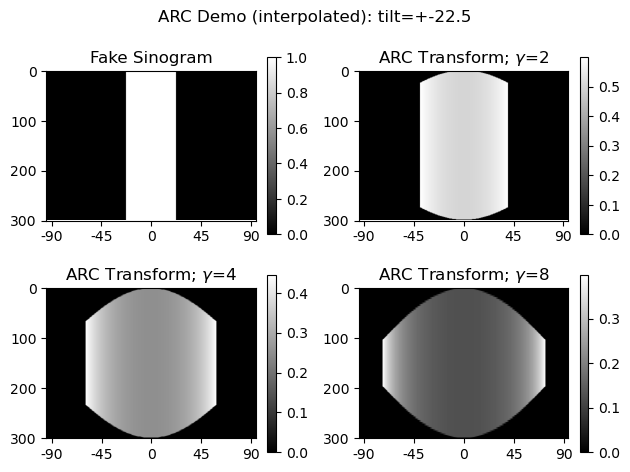

In [92]:
imwidth=400
views=int(400/4)
tilt_angle=np.pi/8
a, b = -tilt_angle, tilt_angle
fake_sino=np.ones((views,1,300))
fake_angles=np.linspace(-tilt_angle, tilt_angle, views)
plt.subplot(2,2,1)
npad=((0,0),(int((imwidth-views)/2)+10,int((imwidth-views)/2)+10))
plt.imshow(np.pad(np.transpose(fake_sino[:,0,:]),npad),cmap='grey')
plt.xticks(np.linspace(10, imwidth+10, 5), np.arange(-90,91,180/4,dtype=int))
plt.yticks(np.linspace(0, fake_sino.shape[2], 4), np.arange(0,301,300/3,dtype=int))
plt.colorbar(fraction=0.040)
plt.title('Fake Sinogram')

gamma=2
fake_sino_tilde, fake_angles_tilde = ARC_sino_transform(fake_sino,fake_angles,gamma,method='linear')
plt.subplot(2,2,2)
sino_tilde=np.transpose(fake_sino_tilde[:,0,:])
reg_ang=np.linspace(fake_angles_tilde.min(), fake_angles_tilde.max(), num=int(views*fake_angles_tilde.max()/tilt_angle))
sino_interp=even_interp_sino(sino_tilde,fake_angles_tilde,reg_ang)
npad=((0,0),(int((imwidth-len(reg_ang))/2)+10,int((imwidth-len(reg_ang))/2)+10))
plt.imshow(np.pad(sino_interp,npad),cmap='grey')
plt.xticks(np.linspace(10, imwidth+10, 5), np.arange(-90,91,180/4,dtype=int))
plt.yticks(np.linspace(0, fake_sino.shape[2], 4), np.arange(0,301,300/3,dtype=int))
plt.colorbar(fraction=0.040)
plt.title('ARC Transform; $\gamma$={}'.format(gamma))

gamma=4
fake_sino_tilde, fake_angles_tilde = ARC_sino_transform(fake_sino,fake_angles,gamma,method='linear')
plt.subplot(2,2,3)
sino_tilde=np.transpose(fake_sino_tilde[:,0,:])
reg_ang=np.linspace(fake_angles_tilde.min(), fake_angles_tilde.max(), num=int(views*fake_angles_tilde.max()/tilt_angle))
sino_interp=even_interp_sino(sino_tilde,fake_angles_tilde,reg_ang)
npad=((0,0),(int((imwidth-len(reg_ang))/2)+10,int((imwidth-len(reg_ang))/2)+10))
plt.imshow(np.pad(sino_interp,npad),cmap='grey')
plt.xticks(np.linspace(10, imwidth+10, 5), np.arange(-90,91,180/4,dtype=int))
plt.yticks(np.linspace(0, fake_sino.shape[2], 4), np.arange(0,301,300/3,dtype=int))
plt.colorbar(fraction=0.040)
plt.title('ARC Transform; $\gamma$={}'.format(gamma))

gamma=8
fake_sino_tilde, fake_angles_tilde = ARC_sino_transform(fake_sino,fake_angles,gamma,method='linear')
plt.subplot(2,2,4)
sino_tilde=np.transpose(fake_sino_tilde[:,0,:])
reg_ang=np.linspace(fake_angles_tilde.min(), fake_angles_tilde.max(), num=int(views*fake_angles_tilde.max()/tilt_angle))
sino_interp=even_interp_sino(sino_tilde,fake_angles_tilde,reg_ang)
npad=((0,0),(int((imwidth-len(reg_ang))/2)+10,int((imwidth-len(reg_ang))/2)+10))
plt.imshow(np.pad(sino_interp,npad),cmap='grey')
plt.xticks(np.linspace(10, imwidth+10, 5), np.arange(-90,91,180/4,dtype=int))
plt.yticks(np.linspace(0, fake_sino.shape[2], 4), np.arange(0,301,300/3,dtype=int))
plt.colorbar(fraction=0.040)
plt.title('ARC Transform; $\gamma$={}'.format(gamma))

plt.suptitle('ARC Demo (interpolated): tilt=+-{}'.format(tilt_angle*180/np.pi))
plt.tight_layout()

In [166]:
R1,GT1,err1,_ ,_ = ARC_Test(2,np.pi/6,20,compress_vertical=False,interpolate=True)
R2,GT2,err2,_ ,_ = ARC_Test(4,np.pi/6,20,compress_vertical=False,interpolate=True)
R3,GT3,err3,_ ,_ = ARC_Test(8,np.pi/6,20,compress_vertical=False,interpolate=True)
R4,GT4,err4,_ ,_ = ARC_Test(2,np.pi/6,20,compress_vertical=False,interpolate=False)
R5,GT5,err5,_ ,_ = ARC_Test(4,np.pi/6,20,compress_vertical=False,interpolate=False)
R6,GT6,err6,_ ,_ = ARC_Test(8,np.pi/6,20,compress_vertical=False,interpolate=False)

Found system matrix: /home/kweisen/.cache/svmbir/sysmatrix/97aecc4f03001dfe93cf.2Dsvmatrix
Reconstructing axial size (rows,cols)=(256,32).
Found system matrix: /home/kweisen/.cache/svmbir/sysmatrix/a3e40e6558b6bc3a9f9f.2Dsvmatrix
ge 0.0492 %
	iteration 42, average change 0.0466 %
	iteration 43, average change 0.0443 %
	iteration 44, average change 0.0411 %
	iteration 45, average change 0.0514 %
	iteration 46, average change 0.0325 %
	iteration 47, average change 0.0308 %
	iteration 48, average change 0.0268 %
	iteration 49, average change 0.0277 %
	iteration 50, average change 0.0449 %
	iteration 51, average change 0.0216 %
	iteration 52, average change 0.0206 %
	iteration 53, average change 0.0189 %
	Reached stopping condition
	Reconstruction time = 5170 ms (iterations only)
Reconstructing...
	iteration 1, average change 238.3093 %
	iteration 2, average change 13.8684 %
	iteration 3, average change 6.0080 %
	iteration 4, average change 3.1403 %
	iteration 5, average change 1.9327 %
	i

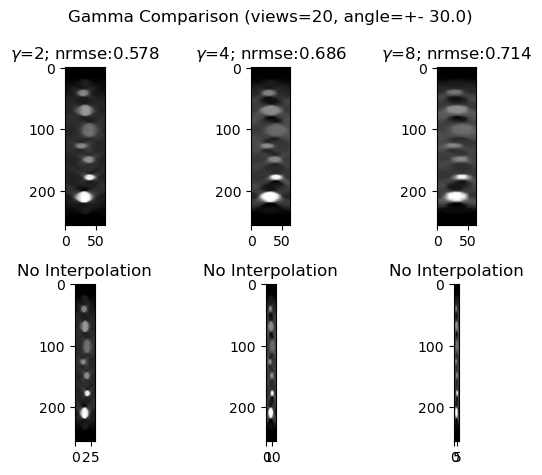

In [167]:
plt.subplot(2,3,1)
plt.imshow(R1[16],cmap='grey')
plt.title('$\gamma$={}; nrmse:{}'.format(2,round(err1,3)))
plt.subplot(2,3,2)
plt.imshow(R2[16],cmap='grey')
plt.title('$\gamma$={}; nrmse:{}'.format(4,round(err2,3)))
plt.subplot(2,3,3)
plt.imshow(R3[16],cmap='grey')
plt.title('$\gamma$={}; nrmse:{}'.format(8,round(err3,3)))
plt.subplot(2,3,4)
plt.imshow(R4[16],cmap='grey')
plt.title('No Interpolation')
plt.subplot(2,3,5)
plt.imshow(R5[16],cmap='grey')
plt.title('No Interpolation')
plt.subplot(2,3,6)
plt.imshow(R6[16],cmap='grey')
plt.title('No Interpolation')
plt.suptitle('Gamma Comparison (views={}, angle=+- {})'.format(20,180/6))
plt.tight_layout()

In [168]:
ang=np.pi/6
views=10
R1,GT1,err1,_ ,_ = ARC_Test(2,ang,views,compress_vertical=False,interpolate=True)
R2,GT2,err2,_ ,_ = ARC_Test(4,ang,views,compress_vertical=False,interpolate=True)
R3,GT3,err3,_ ,_ = ARC_Test(8,ang,views,compress_vertical=False,interpolate=True)
R4,GT4,err4,_ ,_ = ARC_Test(2,ang,views,compress_vertical=False,interpolate=True)
R5,GT5,err5,_ ,_ = ARC_Test(4,ang,views,compress_vertical=False,interpolate=True)
R6,GT6,err6,_ ,_ = ARC_Test(8,ang,views,compress_vertical=False,interpolate=True)

Found system matrix: /home/kweisen/.cache/svmbir/sysmatrix/3bb1cb48835576c77e55.2Dsvmatrix
Reconstructing axial size (rows,cols)=(256,32).
Found system matrix: /home/kweisen/.cache/svmbir/sysmatrix/9197bf850079b14d79b8.2Dsvmatrix
%
	iteration 65, average change 0.0214 %
	iteration 66, average change 0.0217 %
	iteration 67, average change 0.0209 %
	Reached stopping condition
	Reconstruction time = 1774 ms (iterations only)
Reconstructing...
	iteration 1, average change 423.3739 %
	iteration 2, average change 20.3851 %
	iteration 3, average change 6.1838 %
	iteration 4, average change 4.1110 %
	iteration 5, average change 2.3998 %
	iteration 6, average change 1.7808 %
	iteration 7, average change 2.0382 %
	iteration 8, average change 1.4527 %
	iteration 9, average change 1.3431 %
	iteration 10, average change 0.9898 %
	iteration 11, average change 0.8952 %
	iteration 12, average change 0.8051 %
	iteration 13, average change 0.7362 %
	iteration 14, average change 0.7020 %
	iteration 15, a

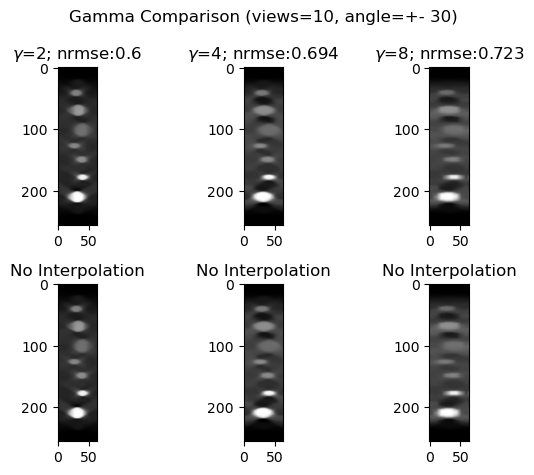

In [169]:
plt.subplot(2,3,1)
plt.imshow(R1[16],cmap='grey')
plt.title('$\gamma$={}; nrmse:{}'.format(2,round(err1,3)))
plt.subplot(2,3,2)
plt.imshow(R2[16],cmap='grey')
plt.title('$\gamma$={}; nrmse:{}'.format(4,round(err2,3)))
plt.subplot(2,3,3)
plt.imshow(R3[16],cmap='grey')
plt.title('$\gamma$={}; nrmse:{}'.format(8,round(err3,3)))
plt.subplot(2,3,4)
plt.imshow(R4[16],cmap='grey')
plt.title('No Interpolation')
plt.subplot(2,3,5)
plt.imshow(R5[16],cmap='grey')
plt.title('No Interpolation')
plt.subplot(2,3,6)
plt.imshow(R6[16],cmap='grey')
plt.title('No Interpolation')
plt.suptitle('Gamma Comparison (views={}, angle=+- {})'.format(views,round(ang*180/np.pi)))
plt.tight_layout()

In [170]:
ang=np.pi/6
views=5
R1,GT1,err1,_ ,_ = ARC_Test(2,ang,views,compress_vertical=False,interpolate=True)
R2,GT2,err2,_ ,_ = ARC_Test(4,ang,views,compress_vertical=False,interpolate=True)
R3,GT3,err3,_ ,_ = ARC_Test(8,ang,views,compress_vertical=False,interpolate=True)
R4,GT4,err4,_ ,_ = ARC_Test(2,ang,views,compress_vertical=False,interpolate=True)
R5,GT5,err5,_ ,_ = ARC_Test(4,ang,views,compress_vertical=False,interpolate=True)
R6,GT6,err6,_ ,_ = ARC_Test(8,ang,views,compress_vertical=False,interpolate=True)

Found system matrix: /home/kweisen/.cache/svmbir/sysmatrix/32281d31bed3d114f889.2Dsvmatrix
Reconstructing axial size (rows,cols)=(256,32).
Found system matrix: /home/kweisen/.cache/svmbir/sysmatrix/db3526b9088c89a8f865.2Dsvmatrix
 change 0.0710 %
	iteration 67, average change 0.0661 %
	iteration 68, average change 0.0584 %
	iteration 69, average change 0.0620 %
	iteration 70, average change 0.0560 %
	iteration 71, average change 0.0541 %
	iteration 72, average change 0.0510 %
	iteration 73, average change 0.0513 %
	iteration 74, average change 0.0493 %
	iteration 75, average change 0.0449 %
	iteration 76, average change 0.0447 %
	iteration 77, average change 0.0441 %
	iteration 78, average change 0.0404 %
	iteration 79, average change 0.0462 %
	iteration 80, average change 0.0512 %
	iteration 81, average change 0.0533 %
	iteration 82, average change 0.0409 %
	iteration 83, average change 0.0391 %
	iteration 84, average change 0.0326 %
	iteration 85, average change 0.0334 %
	iteration 8

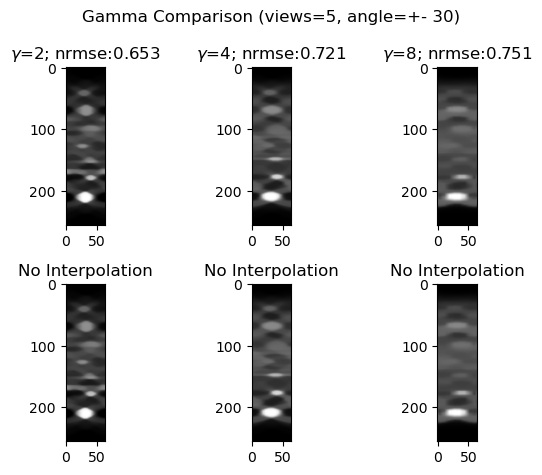

In [171]:
plt.subplot(2,3,1)
plt.imshow(R1[16],cmap='grey')
plt.title('$\gamma$={}; nrmse:{}'.format(2,round(err1,3)))
plt.subplot(2,3,2)
plt.imshow(R2[16],cmap='grey')
plt.title('$\gamma$={}; nrmse:{}'.format(4,round(err2,3)))
plt.subplot(2,3,3)
plt.imshow(R3[16],cmap='grey')
plt.title('$\gamma$={}; nrmse:{}'.format(8,round(err3,3)))
plt.subplot(2,3,4)
plt.imshow(R4[16],cmap='grey')
plt.title('No Interpolation')
plt.subplot(2,3,5)
plt.imshow(R5[16],cmap='grey')
plt.title('No Interpolation')
plt.subplot(2,3,6)
plt.imshow(R6[16],cmap='grey')
plt.title('No Interpolation')
plt.suptitle('Gamma Comparison (views={}, angle=+- {})'.format(views,round(ang*180/np.pi)))
plt.tight_layout()

In [96]:
ang=np.pi/8
views=20
R1,GT1,err1,_ ,_ = ARC_Test(1,1,ang,views,compress_vertical=True,interpolate=True)
R2,GT2,err2,_ ,_ = ARC_Test(2,1,ang,views,compress_vertical=True,interpolate=True)
R3,GT3,err3,_ ,_ = ARC_Test(4,1,ang,views,compress_vertical=True,interpolate=True)
R4,GT4,err4,_ ,_ = ARC_Test(8,1,ang,views,compress_vertical=True,interpolate=True)

R5,GT5,err5,_ ,_ = ARC_Test(1,1,ang,views,compress_vertical=True,interpolate=True)
R6,GT6,err6,_ ,_ = ARC_Test(2,2,ang,views,compress_vertical=True,interpolate=True)
R7,GT7,err7,_ ,_ = ARC_Test(4,4,ang,views,compress_vertical=True,interpolate=True)
R8,GT8,err8,_ ,_ = ARC_Test(8,8,ang,views,compress_vertical=True,interpolate=True)

Found system matrix: /home/kweisen/.cache/svmbir/sysmatrix/7d702c89dd64563a1882.2Dsvmatrix
Reconstructing axial size (rows,cols)=(64,256).
Found system matrix: /home/kweisen/.cache/svmbir/sysmatrix/7d702c89dd64563a1882.2Dsvmatrix
verage change 0.1012 %
	iteration 58, average change 0.1005 %
	iteration 59, average change 0.0944 %
	iteration 60, average change 0.0987 %
	iteration 61, average change 0.0941 %
	iteration 62, average change 0.2045 %
	iteration 63, average change 0.2990 %
	iteration 64, average change 0.1321 %
	iteration 65, average change 0.1692 %
	iteration 66, average change 0.1296 %
	iteration 67, average change 0.0702 %
	iteration 68, average change 0.0691 %
	iteration 69, average change 0.0733 %
	iteration 70, average change 0.0649 %
	iteration 71, average change 0.0637 %
	iteration 72, average change 0.0723 %
	iteration 73, average change 0.0656 %
	iteration 74, average change 0.0541 %
	iteration 75, average change 0.0628 %
	iteration 76, average change 0.0879 %
	itera

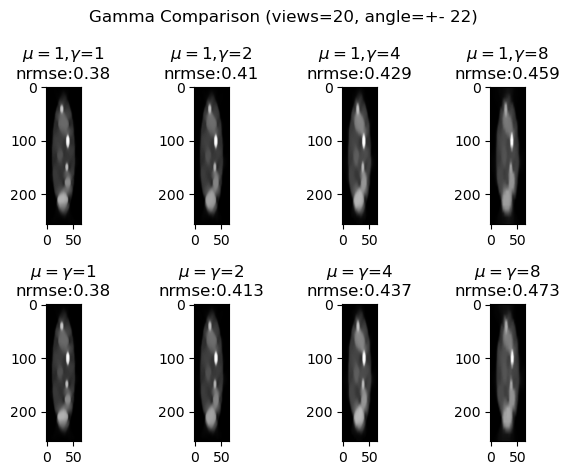

In [99]:
plt.subplot(2,4,1)
plt.imshow(R1[16],cmap='grey')
plt.title('$\mu=1$,$\gamma$={}\nnrmse:{}'.format(1,round(err1,3)))
plt.subplot(2,4,2)
plt.imshow(R2[16],cmap='grey')
plt.title('$\mu=1$,$\gamma$={}\nnrmse:{}'.format(2,round(err2,3)))
plt.subplot(2,4,3)
plt.imshow(R3[16],cmap='grey')
plt.title('$\mu=1$,$\gamma$={}\nnrmse:{}'.format(4,round(err3,3)))
plt.subplot(2,4,4)
plt.imshow(R4[16],cmap='grey')
plt.title('$\mu=1$,$\gamma$={}\nnrmse:{}'.format(8,round(err4,3)))

plt.subplot(2,4,5)
plt.imshow(R1[16],cmap='grey')
plt.title('$\mu=\gamma$={}\nnrmse:{}'.format(1,round(err1,3)))
plt.subplot(2,4,6)
plt.imshow(R6[16],cmap='grey')
plt.title('$\mu=\gamma$={}\nnrmse:{}'.format(2,round(err6,3)))
plt.subplot(2,4,7)
plt.imshow(R7[16],cmap='grey')
plt.title('$\mu=\gamma$={}\nnrmse:{}'.format(4,round(err7,3)))
plt.subplot(2,4,8)
plt.imshow(R8[16],cmap='grey')
plt.title('$\mu=\gamma$={}\nnrmse:{}'.format(8,round(err8,3)))
plt.suptitle('Gamma Comparison (views={}, angle=+- {})'.format(views,round(ang*180/np.pi)))
plt.tight_layout()

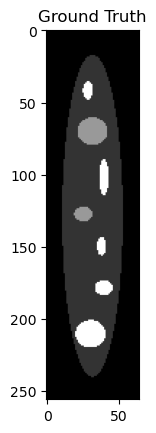

In [95]:
plt.imshow(GT4[16],cmap='grey')
plt.title('Ground Truth')
plt.show()

In [47]:
ang=np.pi/4
views=20
R1,GT1,err1,_ ,_ = ARC_Test(1,ang,views,compress_vertical=True,interpolate=True)
R2,GT2,err2,_ ,_ = ARC_Test(2,ang,views,compress_vertical=True,interpolate=True)
R3,GT3,err3,_ ,_ = ARC_Test(4,ang,views,compress_vertical=True,interpolate=True)
R4,GT4,err4,_ ,_ = ARC_Test(8,ang,views,compress_vertical=True,interpolate=True)

R5,GT5,err5,_ ,_ = ARC_Test(1,ang,views,compress_vertical=True,interpolate=False)
R6,GT6,err6,_ ,_ = ARC_Test(2,ang,views,compress_vertical=True,interpolate=False)
R7,GT7,err7,_ ,_ = ARC_Test(4,ang,views,compress_vertical=True,interpolate=False)
R8,GT8,err8,_ ,_ = ARC_Test(8,ang,views,compress_vertical=True,interpolate=False)

Found system matrix: /home/kweisen/.cache/svmbir/sysmatrix/e457af6e2421d0713c0c.2Dsvmatrix
Reconstructing axial size (rows,cols)=(64,256).
Found system matrix: /home/kweisen/.cache/svmbir/sysmatrix/e457af6e2421d0713c0c.2Dsvmatrix
n 69, average change 0.0662 %
	iteration 70, average change 0.0873 %
	iteration 71, average change 0.0736 %
	iteration 72, average change 0.1002 %
	iteration 73, average change 0.1963 %
	iteration 74, average change 0.0856 %
	iteration 75, average change 0.0817 %
	iteration 76, average change 0.0641 %
	iteration 77, average change 0.0634 %
	iteration 78, average change 0.0972 %
	iteration 79, average change 0.1390 %
	iteration 80, average change 0.0859 %
	iteration 81, average change 0.0547 %
	iteration 82, average change 0.0529 %
	iteration 83, average change 0.0542 %
	iteration 84, average change 0.0652 %
	iteration 85, average change 0.0622 %
	iteration 86, average change 0.0638 %
	iteration 87, average change 0.0494 %
	iteration 88, average change 0.0446 %

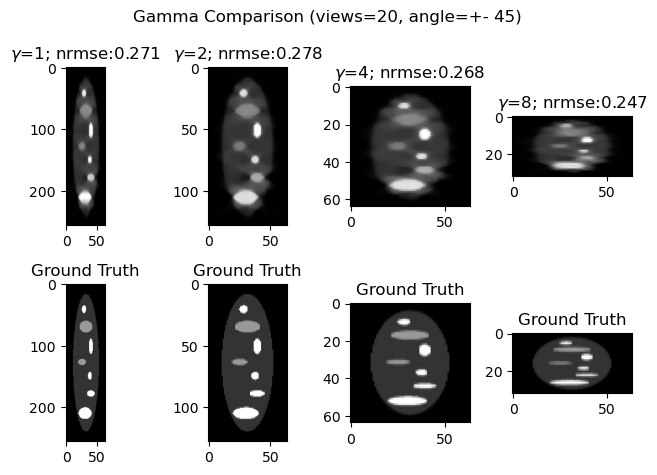

In [48]:
plt.subplot(2,4,1)
plt.imshow(R5[16],cmap='grey')
plt.title('$\gamma$={}; nrmse:{}'.format(1,round(err5,3)))
plt.subplot(2,4,2)
plt.imshow(R6[16],cmap='grey')
plt.title('$\gamma$={}; nrmse:{}'.format(2,round(err6,3)))
plt.subplot(2,4,3)
plt.imshow(R7[16],cmap='grey')
plt.title('$\gamma$={}; nrmse:{}'.format(4,round(err7,3)))
plt.subplot(2,4,4)
plt.imshow(R8[16],cmap='grey')
plt.title('$\gamma$={}; nrmse:{}'.format(8,round(err8,3)))

plt.subplot(2,4,5)
plt.imshow(GT5[16],cmap='grey')
plt.title('Ground Truth')
plt.subplot(2,4,6)
plt.imshow(GT6[16],cmap='grey')
plt.title('Ground Truth')
plt.subplot(2,4,7)
plt.imshow(GT7[16],cmap='grey')
plt.title('Ground Truth')
plt.subplot(2,4,8)
plt.imshow(GT8[16],cmap='grey')
plt.title('Ground Truth')
plt.suptitle('Gamma Comparison (views={}, angle=+- {})'.format(views,round(ang*180/np.pi)))
plt.tight_layout()

In [49]:

ang = np.pi / 8
views = 20
R1,GT1,err1,_ ,_ = ARC_Test(1,ang,views,compress_vertical=True,interpolate=True)
R2,GT2,err2,_ ,_ = ARC_Test(2,ang,views,compress_vertical=True,interpolate=True)
R3,GT3,err3,_ ,_ = ARC_Test(4,ang,views,compress_vertical=True,interpolate=True)
R4,GT4,err4,_ ,_ = ARC_Test(8,ang,views,compress_vertical=True,interpolate=True)

R5,GT5,err5,_ ,_ = ARC_Test(1,ang,views,compress_vertical=True,interpolate=False)
R6,GT6,err6,_ ,_ = ARC_Test(2,ang,views,compress_vertical=True,interpolate=False)
R7,GT7,err7,_ ,_ = ARC_Test(4,ang,views,compress_vertical=True,interpolate=False)
R8,GT8,err8,_ ,_ = ARC_Test(8,ang,views,compress_vertical=True,interpolate=False)

Found system matrix: /home/kweisen/.cache/svmbir/sysmatrix/7d702c89dd64563a1882.2Dsvmatrix
Reconstructing axial size (rows,cols)=(64,256).
Found system matrix: /home/kweisen/.cache/svmbir/sysmatrix/7d702c89dd64563a1882.2Dsvmatrix
iteration 22, average change 0.5283 %
	iteration 23, average change 1.3280 %
	iteration 24, average change 0.4075 %
	iteration 25, average change 0.3987 %
	iteration 26, average change 0.4805 %
	iteration 27, average change 0.8389 %
	iteration 28, average change 0.3491 %
	iteration 29, average change 0.2736 %
	iteration 30, average change 0.3001 %
	iteration 31, average change 0.2735 %
	iteration 32, average change 0.3993 %
	iteration 33, average change 0.3579 %
	iteration 34, average change 0.2504 %
	iteration 35, average change 0.2389 %
	iteration 36, average change 0.2032 %
	iteration 37, average change 0.2625 %
	iteration 38, average change 0.3379 %
	iteration 39, average change 0.1871 %
	iteration 40, average change 0.1784 %
	iteration 41, average change 

<Figure size 640x480 with 0 Axes>

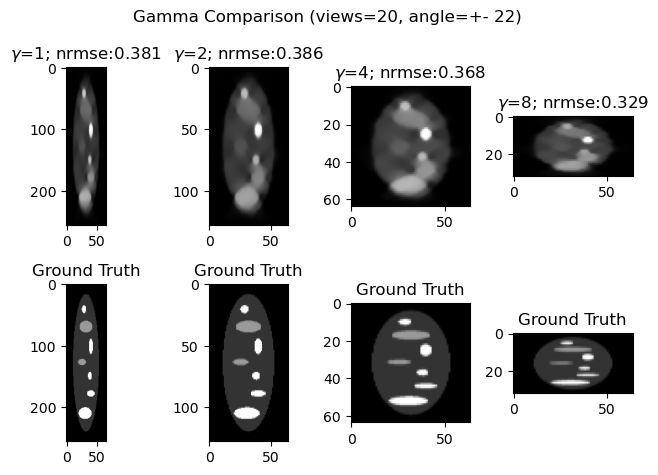

In [50]:
plt.subplot(2,4,1)
plt.imshow(R5[16],cmap='grey')
plt.title('$\gamma$={}; nrmse:{}'.format(1,round(err5,3)))
plt.subplot(2,4,2)
plt.imshow(R6[16],cmap='grey')
plt.title('$\gamma$={}; nrmse:{}'.format(2,round(err6,3)))
plt.subplot(2,4,3)
plt.imshow(R7[16],cmap='grey')
plt.title('$\gamma$={}; nrmse:{}'.format(4,round(err7,3)))
plt.subplot(2,4,4)
plt.imshow(R8[16],cmap='grey')
plt.title('$\gamma$={}; nrmse:{}'.format(8,round(err8,3)))

plt.subplot(2,4,5)
plt.imshow(GT5[16],cmap='grey')
plt.title('Ground Truth')
plt.subplot(2,4,6)
plt.imshow(GT6[16],cmap='grey')
plt.title('Ground Truth')
plt.subplot(2,4,7)
plt.imshow(GT7[16],cmap='grey')
plt.title('Ground Truth')
plt.subplot(2,4,8)
plt.imshow(GT8[16],cmap='grey')
plt.title('Ground Truth')
plt.suptitle('Gamma Comparison (views={}, angle=+- {})'.format(views,round(ang*180/np.pi)))
plt.tight_layout()

In [52]:
ang = np.pi / 16
views = 20
# R1,GT1,err1,_ ,_ = ARC_Test(1,ang,views,compress_vertical=True,interpolate=True)
# R2,GT2,err2,_ ,_ = ARC_Test(2,ang,views,compress_vertical=True,interpolate=True)
# R3,GT3,err3,_ ,_ = ARC_Test(4,ang,views,compress_vertical=True,interpolate=True)
# R4,GT4,err4,_ ,_ = ARC_Test(8,ang,views,compress_vertical=True,interpolate=True)

R5,GT5,err5,_ ,_ = ARC_Test(1,ang,views,compress_vertical=True,interpolate=False)
R6,GT6,err6,_ ,_ = ARC_Test(2,ang,views,compress_vertical=True,interpolate=False)
R7,GT7,err7,_ ,_ = ARC_Test(4,ang,views,compress_vertical=True,interpolate=False)
R8,GT8,err8,_ ,_ = ARC_Test(8,ang,views,compress_vertical=True,interpolate=False)

Found system matrix: /home/kweisen/.cache/svmbir/sysmatrix/936b2a050fc27ef99fe1.2Dsvmatrix
Reconstructing axial size (rows,cols)=(64,256).
Found system matrix: /home/kweisen/.cache/svmbir/sysmatrix/936b2a050fc27ef99fe1.2Dsvmatrix
ge change 0.0278 %
	iteration 86, average change 0.0310 %
	iteration 87, average change 0.0266 %
	iteration 88, average change 0.0246 %
	iteration 89, average change 0.0668 %
	iteration 90, average change 0.2499 %
	iteration 91, average change 0.0223 %
	iteration 92, average change 0.0233 %
	iteration 93, average change 0.0190 %
	Reached stopping condition
	Reconstruction time = 1515 ms (iterations only)
Reconstructing...
	iteration 1, average change 211.3965 %
	iteration 2, average change 8.7891 %
	iteration 3, average change 4.2613 %
	iteration 4, average change 3.3108 %
	iteration 5, average change 2.4431 %
	iteration 6, average change 1.5860 %
	iteration 7, average change 1.4103 %
	iteration 8, average change 1.2526 %
	iteration 9, average change 1.1160 %


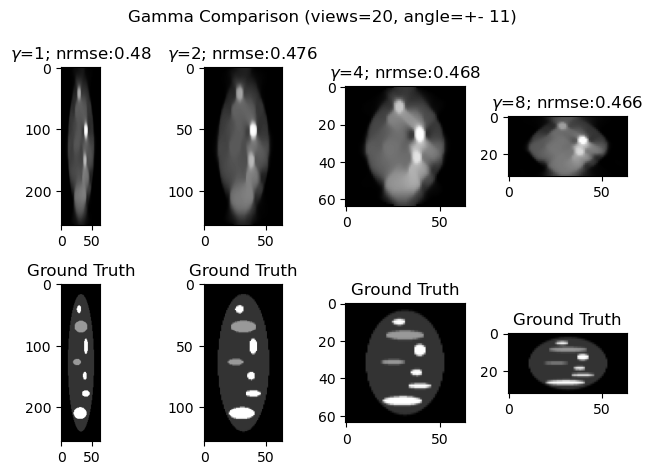

In [53]:
plt.subplot(2,4,1)
plt.imshow(R5[16],cmap='grey')
plt.title('$\gamma$={}; nrmse:{}'.format(1,round(err5,3)))
plt.subplot(2,4,2)
plt.imshow(R6[16],cmap='grey')
plt.title('$\gamma$={}; nrmse:{}'.format(2,round(err6,3)))
plt.subplot(2,4,3)
plt.imshow(R7[16],cmap='grey')
plt.title('$\gamma$={}; nrmse:{}'.format(4,round(err7,3)))
plt.subplot(2,4,4)
plt.imshow(R8[16],cmap='grey')
plt.title('$\gamma$={}; nrmse:{}'.format(8,round(err8,3)))

plt.subplot(2,4,5)
plt.imshow(GT5[16],cmap='grey')
plt.title('Ground Truth')
plt.subplot(2,4,6)
plt.imshow(GT6[16],cmap='grey')
plt.title('Ground Truth')
plt.subplot(2,4,7)
plt.imshow(GT7[16],cmap='grey')
plt.title('Ground Truth')
plt.subplot(2,4,8)
plt.imshow(GT8[16],cmap='grey')
plt.title('Ground Truth')
plt.suptitle('Gamma Comparison (views={}, angle=+- {})'.format(views,round(ang*180/np.pi)))
plt.tight_layout()

Testing ARC and prerescaling the image:

In [373]:
def ARC_compare(gamma,theta_range,num_views,compress_vertical=True,method='cubic',old_interp=False):
    num_rows = 256
    num_cols = 64
    num_slices = 33
    # display_slice = 16 # Display slice at z=-0.0
    tilt_angle=theta_range
    # Reconstruction parameters
    snr_db = 30.0
    sharpness = 0.0
    T = 0.25
    p = 1.2
    # Display parameters
    vmin = 0.0
    vmax = 1.1
    phantom = svmbir.phantom.gen_microscopy_sample_3d(num_rows,num_cols,num_slices)
    if compress_vertical:
        Scaled_phantom=rescale(phantom,(1,1/gamma,1),order=3,preserve_range=True)
        phantom= np.rot90(phantom,axes=(1,2))
        Scaled_phantom = np.rot90(Scaled_phantom,axes=(1,2))
        num_rows=64
        num_cols=256
        new_rows=64
        new_cols=int(256/gamma)
    else:
        Scaled_phantom=rescale(phantom,(1,1,1/gamma,),order=3,preserve_range=True)
        new_rows=256
        new_cols=int(64/gamma)


    # Generate the array of view angles
    angles = np.linspace(-tilt_angle, tilt_angle, num_views)

    # Generate sinogram by projecting phantom
    sino = svmbir.project(phantom, angles, max(num_rows, num_cols))

    if old_interp:
        sino_tilde, new_angles = ARC_sino_transform_old(sino,angles,gamma)
    else:
        sino_tilde, new_angles = ARC_sino_transform(sino,angles,gamma,method=method)

    scaled_sino=svmbir.project(Scaled_phantom, new_angles, max(new_rows, new_cols))

    # Determine resulting number of views, slices, and channels
    (num_views, num_slices, num_channels) = sino_tilde.shape


    # Perform ARC MBIR reconstruction
    ARC_recon = svmbir.recon(sino_tilde, new_angles, num_rows=num_rows, num_cols=new_cols, T=T, p=p, sharpness=sharpness, snr_db=snr_db )
    scaled_recon= svmbir.recon(scaled_sino, new_angles, num_rows=num_rows, num_cols=new_cols, T=T, p=p, sharpness=sharpness, snr_db=snr_db )

    if compress_vertical:
        phantom= np.rot90(phantom,k=-1,axes=(1,2))
        Scaled_phantom= np.rot90(Scaled_phantom,k=-1,axes=(1,2))
        scaled_recon= np.rot90(scaled_recon,k=-1,axes=(1,2))
        ARC_recon= np.rot90(ARC_recon,k=-1,axes=(1,2))

    nrmse = svmbir.phantom.nrmse(ARC_recon, scaled_recon)

    return ARC_recon, scaled_recon, nrmse,phantom, Scaled_phantom

Found system matrix: /home/kweisen/.cache/svmbir/sysmatrix/7d702c89dd64563a1882.2Dsvmatrix
Found system matrix: /home/kweisen/.cache/svmbir/sysmatrix/7d702c89dd64563a1882.2Dsvmatrix
Reconstructing axial size (rows,cols)=(64,256).
Found system matrix: /home/kweisen/.cache/svmbir/sysmatrix/7d702c89dd64563a1882.2Dsvmatrix

	iteration 18, average change 0.7792 %
	iteration 19, average change 0.6534 %
	iteration 20, average change 0.4606 %
	iteration 21, average change 0.4243 %
	iteration 22, average change 0.4010 %
	iteration 23, average change 0.3825 %
	iteration 24, average change 0.3486 %
	iteration 25, average change 0.3263 %
	iteration 26, average change 0.3936 %
	iteration 27, average change 0.5110 %
	iteration 28, average change 0.4722 %
	iteration 29, average change 0.3713 %
	iteration 30, average change 0.2498 %
	iteration 31, average change 0.2391 %
	iteration 32, average change 0.2282 %
	iteration 33, average change 0.2124 %
	iteration 34, average change 0.2015 %
	iteration 35, 

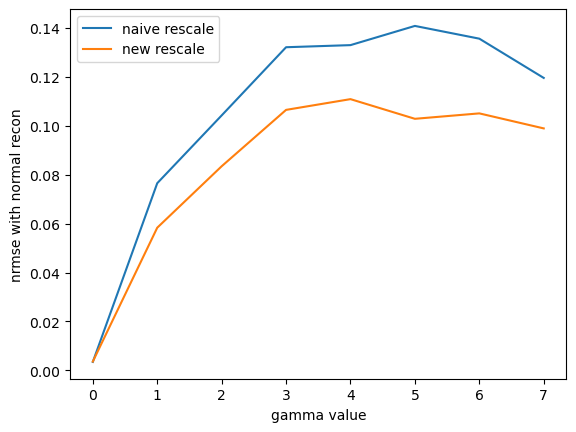

In [375]:
ang = np.pi / 8
views = 20
old=np.zeros(8)
new=np.zeros(8)
gamma_vec=np.array([1,2,3,4,5,6,7,8])
for i,gamma in enumerate(gamma_vec):
    _, _, nrmse_new, _, _ = ARC_compare(gamma, ang, views, compress_vertical=True)
    new[i]=nrmse_new
    _, _, nrmse_old, _, _ = ARC_compare(gamma, ang, views, compress_vertical=True,old_interp=True)
    old[i]=nrmse_old


In [382]:
np.concatenate((np.array([0]),old))

array([0.        , 0.00349425, 0.07645792, 0.10413004, 0.13197206,
       0.13283023, 0.1406711 , 0.13546859, 0.11943983])

In [386]:
old1=old
new1=new

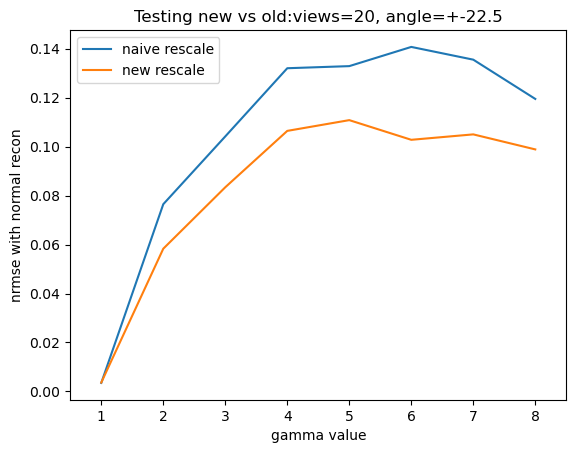

In [388]:
plt.plot(gamma_vec,old1)
plt.plot(gamma_vec,new1)
plt.xlim([0.5,8.5])
plt.xlabel('gamma value')
plt.ylabel('nrmse with normal recon')
plt.legend(['naive rescale','new rescale'])
plt.title('Testing new vs old:views={}, angle=+-{}'.format(views, round(ang * 180 / np.pi, 2)))
plt.show()

In [389]:
ang = np.pi / 4
views = 20
old2=np.zeros(8)
new2=np.zeros(8)
gamma_vec=np.array([1,2,3,4,5,6,7,8])
for i,gamma in enumerate(gamma_vec):
    _, _, nrmse_new, _, _ = ARC_compare(gamma, ang, views, compress_vertical=True)
    new2[i]=nrmse_new
    _, _, nrmse_old, _, _ = ARC_compare(gamma, ang, views, compress_vertical=True,old_interp=True)
    old2[i]=nrmse_old

Found system matrix: /home/kweisen/.cache/svmbir/sysmatrix/e457af6e2421d0713c0c.2Dsvmatrix
Found system matrix: /home/kweisen/.cache/svmbir/sysmatrix/e457af6e2421d0713c0c.2Dsvmatrix
Reconstructing axial size (rows,cols)=(64,256).
Found system matrix: /home/kweisen/.cache/svmbir/sysmatrix/e457af6e2421d0713c0c.2Dsvmatrix
0.0288 %
	iteration 85, average change 0.0280 %
	iteration 86, average change 0.0375 %
	iteration 87, average change 0.0550 %
	iteration 88, average change 0.0391 %
	iteration 89, average change 0.0230 %
	iteration 90, average change 0.0263 %
	iteration 91, average change 0.0239 %
	iteration 92, average change 0.0213 %
	iteration 93, average change 0.0201 %
	Reached stopping condition
	Reconstruction time = 1153 ms (iterations only)
Reconstructing...
	iteration 1, average change 225.7425 %
	iteration 2, average change 17.1749 %
	iteration 3, average change 7.1152 %
	iteration 4, average change 3.4188 %
	iteration 5, average change 2.2416 %
	iteration 6, average change 1.

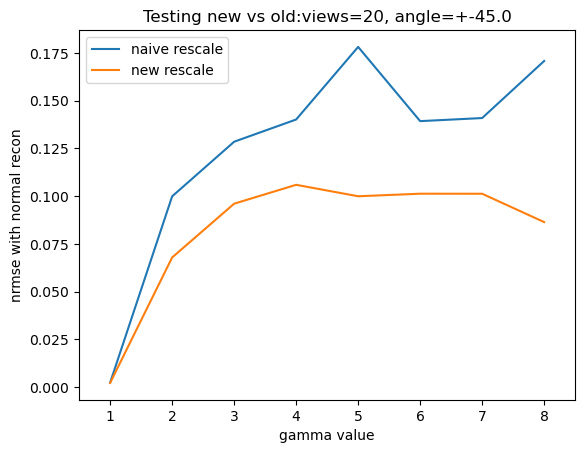

In [390]:
plt.plot(gamma_vec,old2)
plt.plot(gamma_vec,new2)
plt.xlim([0.5,8.5])
plt.xlabel('gamma value')
plt.ylabel('nrmse with normal recon')
plt.legend(['naive rescale','new rescale'])
plt.title('Testing new vs old:views={}, angle=+-{}'.format(views, round(ang * 180 / np.pi, 2)))
plt.show()

In [391]:
ang = np.pi / 16
views = 20
old3=np.zeros(8)
new3=np.zeros(8)
gamma_vec=np.array([1,2,3,4,5,6,7,8])
for i,gamma in enumerate(gamma_vec):
    _, _, nrmse_new, _, _ = ARC_compare(gamma, ang, views, compress_vertical=True)
    new3[i]=nrmse_new
    _, _, nrmse_old, _, _ = ARC_compare(gamma, ang, views, compress_vertical=True,old_interp=True)
    old3[i]=nrmse_old

Found system matrix: /home/kweisen/.cache/svmbir/sysmatrix/936b2a050fc27ef99fe1.2Dsvmatrix
Found system matrix: /home/kweisen/.cache/svmbir/sysmatrix/936b2a050fc27ef99fe1.2Dsvmatrix
Reconstructing axial size (rows,cols)=(64,256).
Found system matrix: /home/kweisen/.cache/svmbir/sysmatrix/936b2a050fc27ef99fe1.2Dsvmatrix
hange 0.2982 %
	iteration 59, average change 0.0780 %
	iteration 60, average change 0.0983 %
	iteration 61, average change 0.0721 %
	iteration 62, average change 0.0685 %
	iteration 63, average change 0.0597 %
	iteration 64, average change 0.1148 %
	iteration 65, average change 0.0721 %
	iteration 66, average change 0.0609 %
	iteration 67, average change 0.0548 %
	iteration 68, average change 0.0434 %
	iteration 69, average change 0.0557 %
	iteration 70, average change 0.0526 %
	iteration 71, average change 0.0520 %
	iteration 72, average change 0.0444 %
	iteration 73, average change 0.0485 %
	iteration 74, average change 0.0637 %
	iteration 75, average change 0.0474 %
	

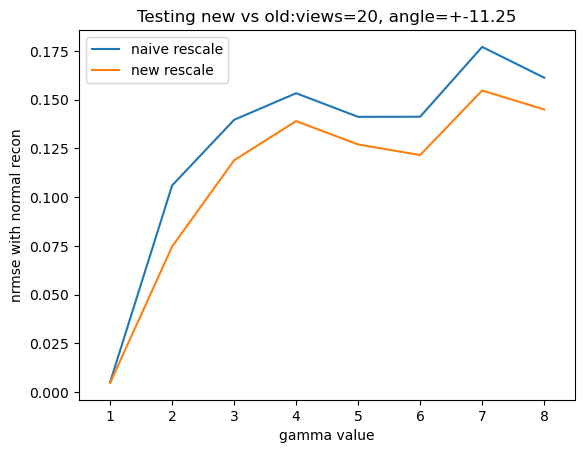

In [392]:
plt.plot(gamma_vec,old3)
plt.plot(gamma_vec,new3)
plt.xlim([0.5,8.5])
plt.xlabel('gamma value')
plt.ylabel('nrmse with normal recon')
plt.legend(['naive rescale','new rescale'])
plt.title('Testing new vs old:views={}, angle=+-{}'.format(views, round(ang * 180 / np.pi, 2)))
plt.show()

Found system matrix: /home/kweisen/.cache/svmbir/sysmatrix/936b2a050fc27ef99fe1.2Dsvmatrix
Found system matrix: /home/kweisen/.cache/svmbir/sysmatrix/936b2a050fc27ef99fe1.2Dsvmatrix
Reconstructing axial size (rows,cols)=(64,256).
Found system matrix: /home/kweisen/.cache/svmbir/sysmatrix/936b2a050fc27ef99fe1.2Dsvmatrix
, average change 0.8073 %
	iteration 15, average change 0.6587 %
	iteration 16, average change 0.5882 %
	iteration 17, average change 0.5341 %
	iteration 18, average change 0.5065 %
	iteration 19, average change 0.4603 %
	iteration 20, average change 0.4366 %
	iteration 21, average change 0.4017 %
	iteration 22, average change 0.3777 %
	iteration 23, average change 0.3584 %
	iteration 24, average change 0.3312 %
	iteration 25, average change 0.3150 %
	iteration 26, average change 0.2972 %
	iteration 27, average change 0.4500 %
	iteration 28, average change 0.3363 %
	iteration 29, average change 0.3185 %
	iteration 30, average change 0.3927 %
	iteration 31, average change

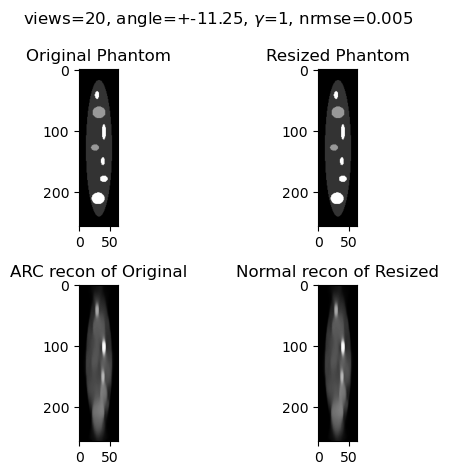

In [287]:
gamma = 1
ang = np.pi / 16
views = 20
R, SR, nrmse, OldPhantom, NewPhantom = ARC_compare(gamma, ang, views, compress_vertical=True)
plt.subplot(2, 2, 1)
plt.imshow(OldPhantom[16], cmap='grey')
plt.title("Original Phantom")

plt.subplot(2, 2, 2)
plt.imshow(NewPhantom[16], cmap='grey')
plt.title("Resized Phantom")

plt.subplot(2, 2, 3)
plt.imshow(R[16], cmap='grey')
plt.title("ARC recon of Original")

plt.subplot(2, 2, 4)
plt.imshow(SR[16], cmap='grey')
plt.title('Normal recon of Resized')

plt.suptitle('views={}, angle=+-{}, $\gamma$={}, nrmse={:.3f}'.format(views, round(ang * 180 / np.pi, 2), gamma, nrmse))
plt.tight_layout()

Found system matrix: /home/kweisen/.cache/svmbir/sysmatrix/7d702c89dd64563a1882.2Dsvmatrix
Found system matrix: /home/kweisen/.cache/svmbir/sysmatrix/0fc6f8fe8cc93b078b81.2Dsvmatrix
Reconstructing axial size (rows,cols)=(64,64).
Found system matrix: /home/kweisen/.cache/svmbir/sysmatrix/3efd36a2be05b8c0d72f.2Dsvmatrix
iteration 27, average change 0.1996 %
	iteration 28, average change 0.1841 %
	iteration 29, average change 0.2427 %
	iteration 30, average change 0.1726 %
	iteration 31, average change 0.1577 %
	iteration 32, average change 0.2250 %
	iteration 33, average change 0.1411 %
	iteration 34, average change 0.1312 %
	iteration 35, average change 0.1195 %
	iteration 36, average change 0.1195 %
	iteration 37, average change 0.1080 %
	iteration 38, average change 0.1067 %
	iteration 39, average change 0.1028 %
	iteration 40, average change 0.0957 %
	iteration 41, average change 0.0870 %
	iteration 42, average change 0.0834 %
	iteration 43, average change 0.0972 %
	iteration 44, ave

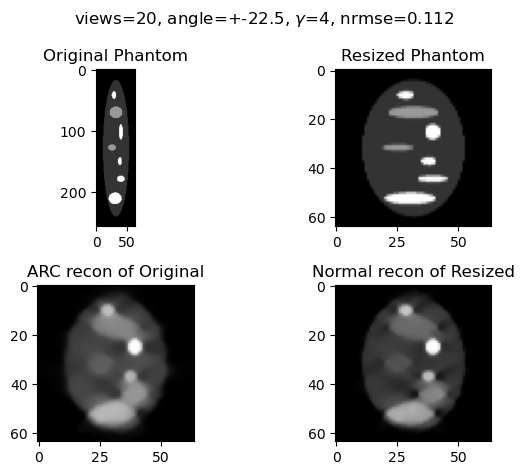

In [121]:
gamma=4
ang = np.pi / 8
views = 20
R, SR, nrmse, OldPhantom, NewPhantom = ARC_compare(gamma, ang, views, compress_vertical=True,method='linear')
plt.subplot(2,2,1)
plt.imshow(OldPhantom[16],cmap='grey')
plt.title("Original Phantom")

plt.subplot(2,2,2)
plt.imshow(NewPhantom[16],cmap='grey')
plt.title("Resized Phantom")

plt.subplot(2,2,3)
plt.imshow(R[16],cmap='grey')
plt.title("ARC recon of Original")

plt.subplot(2,2,4)
plt.imshow(SR[16],cmap='grey')
plt.title('Normal recon of Resized')

plt.suptitle('views={}, angle=+-{}, $\gamma$={}, nrmse={:.3f}'.format(views, round(ang * 180 / np.pi, 2), gamma, nrmse))
plt.tight_layout()

Found system matrix: /home/kweisen/.cache/svmbir/sysmatrix/e457af6e2421d0713c0c.2Dsvmatrix
Found system matrix: /home/kweisen/.cache/svmbir/sysmatrix/5b1446dc24c413dadf91.2Dsvmatrix
Reconstructing axial size (rows,cols)=(64,128).
Found system matrix: /home/kweisen/.cache/svmbir/sysmatrix/077308dfd1f263e70c8a.2Dsvmatrix
1 %
	iteration 96, average change 0.0444 %
	iteration 97, average change 0.0420 %
	iteration 98, average change 0.0273 %
	iteration 99, average change 0.0259 %
	iteration 100, average change 0.0245 %
	Reconstruction time = 11485 ms (iterations only)
Reconstructing...
	iteration 1, average change 194.9176 %
	iteration 2, average change 11.2084 %
	iteration 3, average change 6.8898 %
	iteration 4, average change 3.1835 %
	iteration 5, average change 2.0582 %
	iteration 6, average change 1.6156 %
	iteration 7, average change 1.9386 %
	iteration 8, average change 1.2366 %
	iteration 9, average change 1.0707 %
	iteration 10, average change 1.3552 %
	iteration 11, average chan

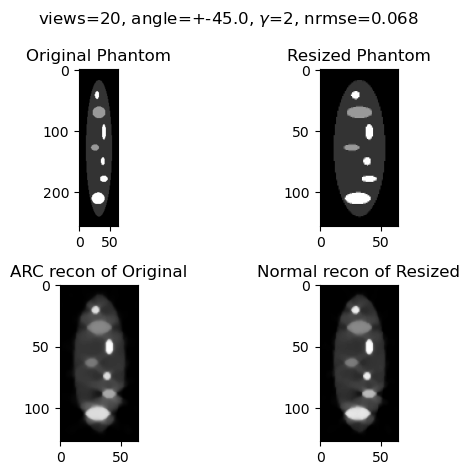

In [123]:
gamma=2
ang = np.pi / 4
views = 20
R, SR, nrmse, OldPhantom, NewPhantom = ARC_compare(gamma, ang, views, compress_vertical=True,method='cubic')
plt.subplot(2,2,1)
plt.imshow(OldPhantom[16],cmap='grey')
plt.title("Original Phantom")

plt.subplot(2,2,2)
plt.imshow(NewPhantom[16],cmap='grey')
plt.title("Resized Phantom")

plt.subplot(2,2,3)
plt.imshow(R[16],cmap='grey')
plt.title("ARC recon of Original")

plt.subplot(2,2,4)
plt.imshow(SR[16],cmap='grey')
plt.title('Normal recon of Resized')

plt.suptitle('views={}, angle=+-{}, $\gamma$={}, nrmse={:.3f}'.format(views, round(ang * 180 / np.pi, 2), gamma,nrmse,3))
plt.tight_layout()

Found system matrix: /home/kweisen/.cache/svmbir/sysmatrix/7d702c89dd64563a1882.2Dsvmatrix
Found system matrix: /home/kweisen/.cache/svmbir/sysmatrix/550f61636ab1226cbf1b.2Dsvmatrix
Reconstructing axial size (rows,cols)=(64,32).
Found system matrix: /home/kweisen/.cache/svmbir/sysmatrix/7d61005a76380df1f5d7.2Dsvmatrix
, average change 0.2022 %
	iteration 29, average change 0.1876 %
	iteration 30, average change 0.1800 %
	iteration 31, average change 0.1676 %
	iteration 32, average change 0.1876 %
	iteration 33, average change 0.1504 %
	iteration 34, average change 0.1421 %
	iteration 35, average change 0.1300 %
	iteration 36, average change 0.1259 %
	iteration 37, average change 0.1577 %
	iteration 38, average change 0.1372 %
	iteration 39, average change 0.1061 %
	iteration 40, average change 0.0997 %
	iteration 41, average change 0.0940 %
	iteration 42, average change 0.0875 %
	iteration 43, average change 0.1040 %
	iteration 44, average change 0.0820 %
	iteration 45, average change 

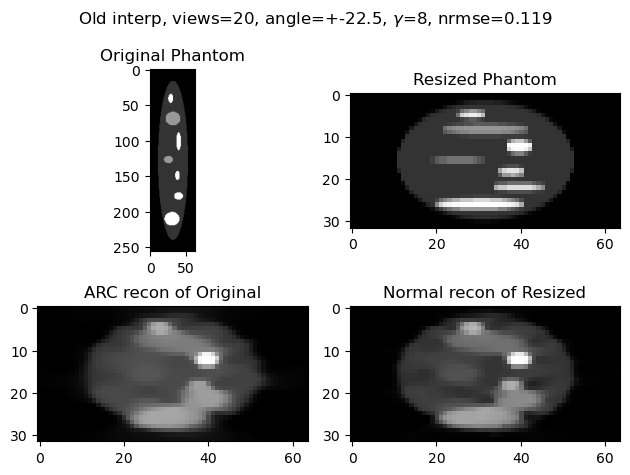

In [124]:
gamma = 8
ang = np.pi / 8
views = 20
R, SR, nrmse, OldPhantom, NewPhantom = ARC_compare(gamma, ang, views, compress_vertical=True,old_interp=True)
plt.subplot(2, 2, 1)
plt.imshow(OldPhantom[16], cmap='grey')
plt.title("Original Phantom")

plt.subplot(2, 2, 2)
plt.imshow(NewPhantom[16], cmap='grey')
plt.title("Resized Phantom")

plt.subplot(2, 2, 3)
plt.imshow(R[16], cmap='grey')
plt.title("ARC recon of Original")

plt.subplot(2, 2, 4)
plt.imshow(SR[16], cmap='grey')
plt.title('Normal recon of Resized')
plt.suptitle('Old interp, views={}, angle=+-{}, $\gamma$={}, nrmse={:.3f}'.format(views, round(ang * 180 / np.pi, 2), gamma, nrmse))
plt.tight_layout()

Found system matrix: /home/kweisen/.cache/svmbir/sysmatrix/7d702c89dd64563a1882.2Dsvmatrix
Found system matrix: /home/kweisen/.cache/svmbir/sysmatrix/550f61636ab1226cbf1b.2Dsvmatrix
Reconstructing axial size (rows,cols)=(64,32).
Found system matrix: /home/kweisen/.cache/svmbir/sysmatrix/7d61005a76380df1f5d7.2Dsvmatrix
ange 225.5981 %
	iteration 2, average change 18.0640 %
	iteration 3, average change 6.2176 %
	iteration 4, average change 3.2325 %
	iteration 5, average change 2.0899 %
	iteration 6, average change 1.5303 %
	iteration 7, average change 1.3486 %
	iteration 8, average change 0.9744 %
	iteration 9, average change 0.8460 %
	iteration 10, average change 1.1152 %
	iteration 11, average change 0.8614 %
	iteration 12, average change 0.5677 %
	iteration 13, average change 0.4173 %
	iteration 14, average change 0.3907 %
	iteration 15, average change 0.6631 %
	iteration 16, average change 0.2879 %
	iteration 17, average change 0.2483 %
	iteration 18, average change 0.2325 %
	iterati

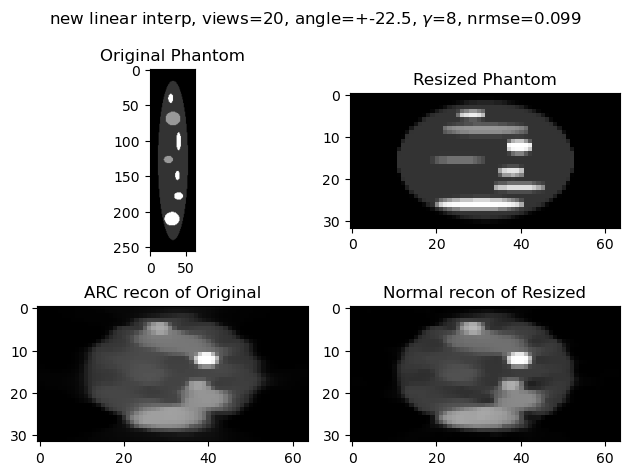

In [127]:
gamma = 8
ang = np.pi / 8
views = 20
R, SR, nrmse, OldPhantom, NewPhantom = ARC_compare(gamma, ang, views, compress_vertical=True,method='cubic')
plt.subplot(2, 2, 1)
plt.imshow(OldPhantom[16], cmap='grey')
plt.title("Original Phantom")

plt.subplot(2, 2, 2)
plt.imshow(NewPhantom[16], cmap='grey')
plt.title("Resized Phantom")

plt.subplot(2, 2, 3)
plt.imshow(R[16], cmap='grey')
plt.title("ARC recon of Original")

plt.subplot(2, 2, 4)
plt.imshow(SR[16], cmap='grey')
plt.title('Normal recon of Resized')
plt.suptitle('new linear interp, views={}, angle=+-{}, $\gamma$={}, nrmse={:.3f}'.format(views, round(ang * 180 / np.pi, 2), gamma, nrmse))
plt.tight_layout()

Found system matrix: /home/kweisen/.cache/svmbir/sysmatrix/936b2a050fc27ef99fe1.2Dsvmatrix
Found system matrix: /home/kweisen/.cache/svmbir/sysmatrix/7f06c7457bde6ddfe99e.2Dsvmatrix
Reconstructing axial size (rows,cols)=(64,32).
Found system matrix: /home/kweisen/.cache/svmbir/sysmatrix/871a0a815eb24c3d3882.2Dsvmatrix
ge change 0.1031 %
	iteration 64, average change 0.1619 %
	iteration 65, average change 0.0638 %
	iteration 66, average change 0.0666 %
	iteration 67, average change 0.0586 %
	iteration 68, average change 0.0567 %
	iteration 69, average change 0.0566 %
	iteration 70, average change 0.0784 %
	iteration 71, average change 0.0868 %
	iteration 72, average change 0.0493 %
	iteration 73, average change 0.0671 %
	iteration 74, average change 0.0449 %
	iteration 75, average change 0.0467 %
	iteration 76, average change 0.0428 %
	iteration 77, average change 0.0394 %
	iteration 78, average change 0.0389 %
	iteration 79, average change 0.0348 %
	iteration 80, average change 0.0801 

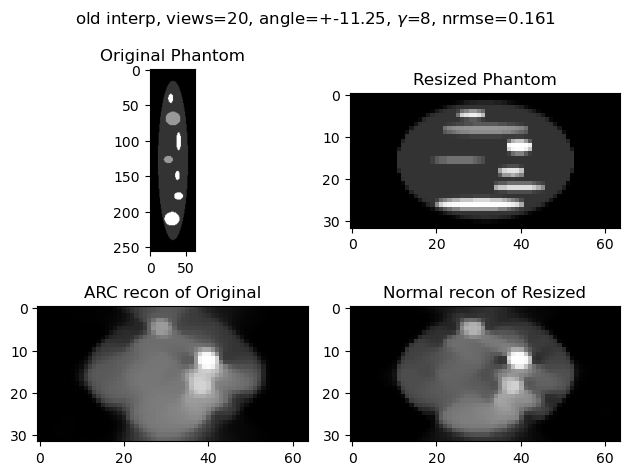

In [128]:
gamma = 8
ang = np.pi / 16
views = 20
R, SR, nrmse, OldPhantom, NewPhantom = ARC_compare(gamma, ang, views, compress_vertical=True,old_interp=True)
plt.subplot(2, 2, 1)
plt.imshow(OldPhantom[16], cmap='grey')
plt.title("Original Phantom")

plt.subplot(2, 2, 2)
plt.imshow(NewPhantom[16], cmap='grey')
plt.title("Resized Phantom")

plt.subplot(2, 2, 3)
plt.imshow(R[16], cmap='grey')
plt.title("ARC recon of Original")

plt.subplot(2, 2, 4)
plt.imshow(SR[16], cmap='grey')
plt.title('Normal recon of Resized')

plt.suptitle('old interp, views={}, angle=+-{}, $\gamma$={}, nrmse={:.3f}'.format(views, round(ang * 180 / np.pi, 2), gamma, nrmse))
plt.tight_layout()

Found system matrix: /home/kweisen/.cache/svmbir/sysmatrix/936b2a050fc27ef99fe1.2Dsvmatrix
Found system matrix: /home/kweisen/.cache/svmbir/sysmatrix/7f06c7457bde6ddfe99e.2Dsvmatrix
Reconstructing axial size (rows,cols)=(64,32).
Found system matrix: /home/kweisen/.cache/svmbir/sysmatrix/871a0a815eb24c3d3882.2Dsvmatrix
 average change 0.2905 %
	iteration 32, average change 0.1479 %
	iteration 33, average change 0.1320 %
	iteration 34, average change 0.1268 %
	iteration 35, average change 0.1256 %
	iteration 36, average change 0.1135 %
	iteration 37, average change 0.1112 %
	iteration 38, average change 0.1017 %
	iteration 39, average change 0.0887 %
	iteration 40, average change 0.0874 %
	iteration 41, average change 0.1822 %
	iteration 42, average change 0.1022 %
	iteration 43, average change 0.0886 %
	iteration 44, average change 0.0679 %
	iteration 45, average change 0.0637 %
	iteration 46, average change 0.0640 %
	iteration 47, average change 0.0566 %
	iteration 48, average change 0

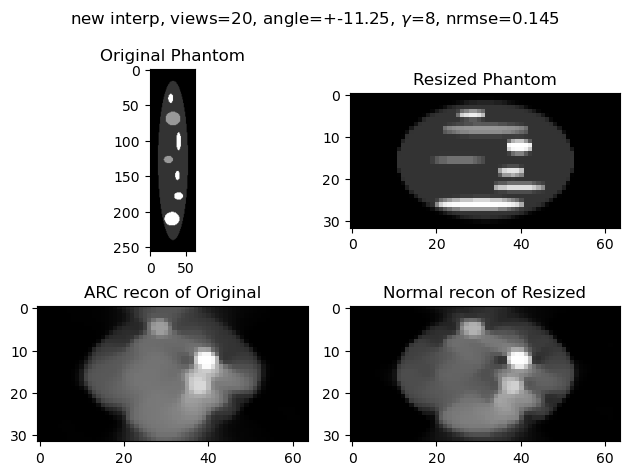

In [129]:
gamma = 8
ang = np.pi / 16
views = 20
R, SR, nrmse, OldPhantom, NewPhantom = ARC_compare(gamma, ang, views, compress_vertical=True)
plt.subplot(2, 2, 1)
plt.imshow(OldPhantom[16], cmap='grey')
plt.title("Original Phantom")

plt.subplot(2, 2, 2)
plt.imshow(NewPhantom[16], cmap='grey')
plt.title("Resized Phantom")

plt.subplot(2, 2, 3)
plt.imshow(R[16], cmap='grey')
plt.title("ARC recon of Original")

plt.subplot(2, 2, 4)
plt.imshow(SR[16], cmap='grey')
plt.title('Normal recon of Resized')

plt.suptitle('new interp, views={}, angle=+-{}, $\gamma$={}, nrmse={:.3f}'.format(views, round(ang * 180 / np.pi, 2), gamma, nrmse))
plt.tight_layout()

In [244]:
num_rows = 256
num_cols = 64
num_slices = 33
phantom = svmbir.phantom.gen_microscopy_sample_3d(num_rows,num_cols,num_slices)
Scaled_phantom=rescale(phantom,(1,1/5,1),preserve_range=True)
plt.subplot(2,2)


TypeError: subplot() takes 1 or 3 positional arguments but 2 were given

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'Microscopy Phantom: slice 16')

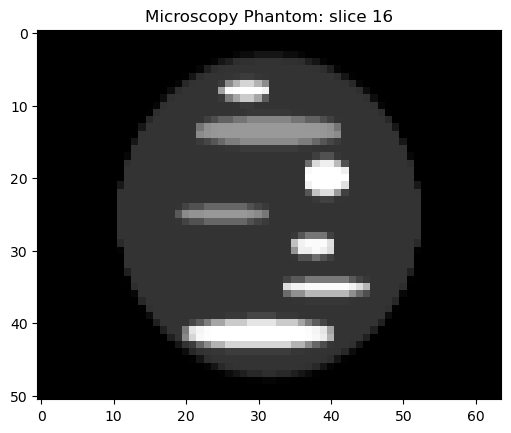

In [137]:
plt.imshow(Scaled_phantom[16],cmap='grey')
plt.title('Microscopy Phantom: slice 16')